# CYBERML - Project

This notebook contains our work for the CYBERML project. We choose the subject **Anomaly detection for tracking attacks** on the **SWaT dataset**.

Our group is composed of :

- Clovis Lechien
- Alexandre Devaux-Rivière
- Florian Segard-Gahery
- Valentin San
- Maël Reynaud

---

### Imports

In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import mlsecu.data_exploration_utils as deu

from typing import Tuple, Any
from os import listdir
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import precision_score, recall_score, f1_score, matthews_corrcoef, balanced_accuracy_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

pd.set_option("display.max_columns", None)

%matplotlib inline

In [90]:
class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

---

### Data exploration / pre processing

#### Create dataframe

In [91]:
path = 'data/swat_newdataset/SWaT.A3_dataset_Jul 19_labelled.xlsx'

df = pd.read_excel(path, skiprows=[0, 2])
df.head()

,GMT +0,Attack,Label,FIT 101,LIT 101,MV 101,P1_STATE,P101 Status,P102 Status,AIT 201,AIT 202,AIT 203,FIT 201,LS 201,LS 202,LSL 203,LSLL 203,MV201,P2_STATE,P201 Status,P202 Status,P203 Status,P204 Status,P205 Status,P206 Status,P207 Status,P208 Status,AIT 301,AIT 302,AIT 303,DPIT 301,FIT 301,LIT 301,MV 301,MV 302,MV 303,MV 304,P3_STATE,P301 Status,P302 Status,AIT 401,AIT 402,FIT 401,LIT 401,LS 401,P4_STATE,P401 Status,P402 Status,P403 Status,P404 Status,UV401,AIT 501,AIT 502,AIT 503,AIT 504,FIT 501,FIT 502,FIT 503,FIT 504,MV 501,MV 502,MV 503,MV 504,P5_STATE,P501 Status,P502 Status,PIT 501,PIT 502,PIT 503,FIT 601,LSH 601,LSH 602,LSH 603,LSL 601,LSL 602,LSL 603,P6 STATE,P601 Status,P602 Status,P603 Status
0,2019-07-20T04:30:00Z,benign,0,0.0,729.8658,1,3,2,1,142.527557,9.293002,198.077423,2.335437,"{u'IsSystem': False, u'Name': u'Inactive', u'V...","{u'IsSystem': False, u'Name': u'Inactive', u'V...","{u'IsSystem': False, u'Name': u'Inactive', u'V...","{u'IsSystem': False, u'Name': u'Inactive', u'V...",2,2,1,1,2,1,2,1,1,1,8.522921,256.431274,143.158966,1.190857,0.000512,730.702100,1,1,1,1,99,1,1,0,87.951805,0.781740,1000.62805,"{u'IsSystem': False, u'Name': u'Inactive', u'V...",4,2,1,1,1,2,7.489618,147.398100,1016.27789,46.065113,0.781594,0.310362,0.623628,0.213432,2,2,1,1,12,2,1,167.601257,2.963509,119.921173,0.00032,"{u'IsSystem': False, u'Name': u'Active', u'Val...","{u'IsSystem': False, u'Name': u'Active', u'Val...","{u'IsSystem': False, u'Name': u'Inactive', u'V...","{u'IsSystem': False, u'Name': u'Inactive', u'V...","{u'IsSystem': False, u'Name': u'Inactive', u'V...","{u'IsSystem': False, u'Name': u'Active', u'Val...",2,1,1,1
1,2019-07-20T04:30:01Z,benign,0,0.0,729.4340,1,3,2,1,142.527557,9.293002,198.385025,2.335437,"{u'IsSystem': False, u'Name': u'Inactive', u'V...","{u'IsSystem': False, u'Name': u'Inactive', u'V...","{u'IsSystem': False, u'Name': u'Inactive', u'V...","{u'IsSystem': False, u'Name': u'Inactive', u'V...",2,2,1,1,2,1,2,1,1,1,8.522921,256.431274,143.158966,1.190857,0.000512,730.902344,1,1,1,1,99,1,1,0,87.823630,0.782380,1000.55115,"{u'IsSystem': False, u'Name': u'Inactive', u'V...",4,2,1,1,1,2,7.489618,147.398100,1016.27789,45.757500,0.782235,0.315102,0.623628,0.212984,2,2,1,1,12,2,1,167.601257,2.963509,119.921173,0.00032,"{u'IsSystem': False, u'Name': u'Active', u'Val...","{u'IsSystem': False, u'Name': u'Active', u'Val...","{u'IsSystem': False, u'Name': u'Inactive', u'V...","{u'IsSystem': False, u'Name': u'Inactive', u'V...","{u'IsSystem': False, u'Name': u'Inactive', u'V...","{u'IsSystem': False, u'Name': u'Active', u'Val...",2,1,1,1
2,2019-07-20T04:30:02.004013Z,benign,0,0.0,729.1200,1,3,2,1,142.527557,9.293002,198.436300,2.335437,"{u'IsSystem': False, u'Name': u'Inactive', u'V...","{u'IsSystem': False, u'Name': u'Inactive', u'V...","{u'IsSystem': False, u'Name': u'Inactive', u'V...","{u'IsSystem': False, u'Name': u'Inactive', u'V...",2,2,1,1,2,1,2,1,1,1,8.522921,256.431274,143.158966,1.190857,0.000512,732.344300,1,1,1,1,99,1,1,0,87.798004,0.783021,1000.28200,"{u'IsSystem': False, u'Name': u'Inactive', u'V...",4,2,1,1,1,2,7.489618,147.398100,1016.27789,45.603690,0.782235,0.317023,0.623628,0.212984,2,2,1,1,12,2,1,167.601257,2.963509,119.921173,0.00032,"{u'IsSystem': False, u'Name': u'Active', u'Val...","{u'IsSystem': False, u'Name': u'Active', u'Val...","{u'IsSystem': False, u'Name': u'Inactive', u'V...","{u'IsSystem': False, u'Name': u'Inactive', u'V...","{u'IsSystem': False, u'Name': u'Inactive', u'V...","{u'IsSystem': False, u'Name': u'Active', u'Val...",2,1,1,1
3,2019-07-20T04:30:03.004013Z,benign,0,0.0,728.6882,1,3,2,1,142.527557,9.289157,198.667000,2.335437,"{u'IsSystem': False, u'Name': u'Inactive', u'V...","{u'IsSystem': False, u'Name': u'Inactive', u'V...","{u'IsSystem': False, u'Name': u'Inactive', u'V...","{u'IsSystem': False, u'Name': u'Inactive', u'V...",2,2,1,1,2,1,2,1,1,1,8.522921,256.431274,143.158966,1.190857,0.000512,732.704800,1,1,1,1,99,1,1,0,87.695465,0.783021,1000.74341,"{u'IsSystem': F

In [92]:
df.columns

Index(['GMT +0', 'Attack', 'Label', 'FIT 101', 'LIT 101', 'MV 101', 'P1_STATE',
       'P101 Status', 'P102 Status', 'AIT 201', 'AIT 202', 'AIT 203',
       'FIT 201', 'LS 201', 'LS 202', 'LSL 203', 'LSLL 203', 'MV201',
       'P2_STATE', 'P201 Status', 'P202 Status', 'P203 Status', 'P204 Status',
       'P205 Status', 'P206 Status', 'P207 Status', 'P208 Status', 'AIT 301',
       'AIT 302', 'AIT 303', 'DPIT 301', 'FIT 301', 'LIT 301', 'MV 301',
       'MV 302', 'MV 303', 'MV 304', 'P3_STATE', 'P301 Status', 'P302 Status',
       'AIT 401', 'AIT 402', 'FIT 401', 'LIT 401', 'LS 401', 'P4_STATE',
       'P401 Status', 'P402 Status', 'P403 Status', 'P404 Status', 'UV401',
       'AIT 501', 'AIT 502', 'AIT 503', 'AIT 504', 'FIT 501', 'FIT 502',
       'FIT 503', 'FIT 504', 'MV 501', 'MV 502', 'MV 503', 'MV 504',
       'P5_STATE', 'P501 Status', 'P502 Status', 'PIT 501', 'PIT 502',
       'PIT 503', 'FIT 601', 'LSH 601', 'LSH 602', 'LSH 603', 'LSL 601',
       'LSL 602', 'LSL 603', 'P6 STA

In [93]:
df['Attack'].unique()

array(['benign', 'Spoofing', 'Switch_ON', 'Switch_close', 'Switch_off'],
      dtype=object)

The function **map_df_num** allow us to convert the columns which contains json like strings (LS201, LS202, LS203...) to int (0 or 1), because the only value changing in these dictionnaries is *Active* or *Inactive*.

In [94]:
def map_df_num(df: pd.DataFrame) -> pd.DataFrame:
    new_df = df.map(lambda x: 0 if isinstance(x, str) and "inactive" in x.lower()
                 else 1 if isinstance(x, str) and "active" in x.lower()
                 else x).copy()

    return new_df

df = map_df_num(df)

In [95]:
df.head()

,GMT +0,Attack,Label,FIT 101,LIT 101,MV 101,P1_STATE,P101 Status,P102 Status,AIT 201,AIT 202,AIT 203,FIT 201,LS 201,LS 202,LSL 203,LSLL 203,MV201,P2_STATE,P201 Status,P202 Status,P203 Status,P204 Status,P205 Status,P206 Status,P207 Status,P208 Status,AIT 301,AIT 302,AIT 303,DPIT 301,FIT 301,LIT 301,MV 301,MV 302,MV 303,MV 304,P3_STATE,P301 Status,P302 Status,AIT 401,AIT 402,FIT 401,LIT 401,LS 401,P4_STATE,P401 Status,P402 Status,P403 Status,P404 Status,UV401,AIT 501,AIT 502,AIT 503,AIT 504,FIT 501,FIT 502,FIT 503,FIT 504,MV 501,MV 502,MV 503,MV 504,P5_STATE,P501 Status,P502 Status,PIT 501,PIT 502,PIT 503,FIT 601,LSH 601,LSH 602,LSH 603,LSL 601,LSL 602,LSL 603,P6 STATE,P601 Status,P602 Status,P603 Status
0,2019-07-20T04:30:00Z,benign,0,0.0,729.8658,1,3,2,1,142.527557,9.293002,198.077423,2.335437,0,0,0,0,2,2,1,1,2,1,2,1,1,1,8.522921,256.431274,143.158966,1.190857,0.000512,730.702100,1,1,1,1,99,1,1,0,87.951805,0.781740,1000.62805,0,4,2,1,1,1,2,7.489618,147.398100,1016.27789,46.065113,0.781594,0.310362,0.623628,0.213432,2,2,1,1,12,2,1,167.601257,2.963509,119.921173,0.00032,1,1,0,0,0,1,2,1,1,1
1,2019-07-20T04:30:01Z,benign,0,0.0,729.4340,1,3,2,1,142.527557,9.293002,198.385025,2.335437,0,0,0,0,2,2,1,1,2,1,2,1,1,1,8.522921,256.431274,143.158966,1.190857,0.000512,730.902344,1,1,1,1,99,1,1,0,87.823630,0.782380,1000.55115,0,4,2,1,1,1,2,7.489618,147.398100,1016.27789,45.757500,0.782235,0.315102,0.623628,0.212984,2,2,1,1,12,2,1,167.601257,2.963509,119.921173,0.00032,1,1,0,0,0,1,2,1,1,1
2,2019-07-20T04:30:02.004013Z,benign,0,0.0,729.1200,1,3,2,1,142.527557,9.293002,198.436300,2.335437,0,0,0,0,2,2,1,1,2,1,2,1,1,1,8.522921,256.431274,143.158966,1.190857,0.000512,732.344300,1,1,1,1,99,1,1,0,87.798004,0.783021,1000.28200,0,4,2,1,1,1,2,7.489618,147.398100,1016.27789,45.603690,0.782235,0.317023,0.623628,0.212984,2,2,1,1,12,2,1,167.601257,2.963509,119.921173,0.00032,1,1,0,0,0,1,2,1,1,1
3,2019-07-20T04:30:03.004013Z,benign,0,0.0,728.6882,1,3,2,1,142.527557,9.289157,198.667000,2.335437,0,0,0,0,2,2,1,1,2,1,2,1,1,1,8.522921,256.431274,143.158966,1.190857,0.000512,732.704800,1,1,1,1,99,1,1,0,87.695465,0.783021,1000.74341,0,4,2,1,1,1,2,7.489618,147.167389,1016.27789,45.603690,0.783133,0.308057,0.623628,0.212792,2,2,1,1,12,2,1,167.601257,2.963509,119.921173,0.00032,1,1,0,0,0,1,2,1,1,1
4,2019-07-20T04:30:04Z,benign,0,0.0,727.7069,1,3,2,1,142.527557,9.289157,198.897720,2.335437,0,0,0,0,2,2,1,1,2,1,2,1,1,1,8.522921,256.431274,143.158966,1.190857,0.000512,732.744800,1,1,1,1,99,1,1,0,87.618560,0.781228,1000.39734,0,4,2,1,1,1,2,7.489618,147.090485,1016.27789,45.219173,0.783773,0.303446,0.623628,0.214009,2,2,1,1,12,2,1,167.601257,2.963509,119.921173,0.00032,1,1,0,0,0,1,2,1,1,1


#### Dataset summary

In [96]:
def get_summary(df : pd.DataFrame) -> pd.DataFrame:
    df_desc = pd.DataFrame(df.describe(include='all').T)
    df_summary = pd.DataFrame({
        'dtype': df.dtypes,
        'unique':df.nunique().values,
        'missing': df.isna().sum().values,
        'duplicates': df.duplicated().sum(),
        'min': df_desc['min'].values,
        'max': df_desc['max'].values,
        'avg': df_desc['mean'].values,
        'std dev': df_desc['std'].values
    })
    return df_summary

In [97]:
get_summary(df).style.background_gradient(cmap='viridis_r', low=0.8)

,dtype,unique,missing,duplicates,min,max,avg,std dev
GMT +0,object,14996,0,0,nan,nan,nan,nan
Attack,object,5,0,0,nan,nan,nan,nan
Label,int64,2,0,0,0.000000,1.000000,0.170245,0.375861
FIT 101,float64,310,0,0,0.000000,4.403484,0.740876,1.634632
LIT 101,float64,4493,0,0,491.169769,825.092957,733.960251,110.960185
MV 101,int64,3,0,0,0.000000,2.000000,1.156175,0.384272
P1_STATE,int64,2,0,0,2.000000,3.000000,2.061616,0.240466
P101 Status,int64,2,0,0,1.000000,2.000000,1.374166,0.483923
P102 Status,int64,1,0,0,1.000000,1.000000,1.000000,0.000000
AIT 201,float64,301,0,0,113.849014,146.821335,138.766501,8.265845


In [98]:
def data_exploration(df : pd.DataFrame) -> None:
    dim = deu.get_nb_of_dimensions(df)
    print(bcolors.HEADER + 'Number of dimensions:' + bcolors.ENDC, dim, '\n')
    print(bcolors.HEADER + 'Number of rows:' + bcolors.ENDC, deu.get_nb_of_rows(df), '\n')
    print(bcolors.HEADER + 'Column names:' + bcolors.ENDC, deu.get_column_names(df), '\n')
    print(bcolors.HEADER + 'Number column names:' + bcolors.ENDC, deu.get_number_column_names(df), '\n')
    print(bcolors.HEADER + 'Object column names:' + bcolors.ENDC, deu.get_object_column_names(df), '\n')

    for i in range(dim):
        col = df.columns[i]
        if len(deu.get_unique_values(df, col)) > 20:
            print(bcolors.HEADER + f'Unique values of column [{col}]:' + bcolors.ENDC, len(deu.get_unique_values(df, col)), "numerical values", '\n')
        else:
            print(bcolors.HEADER + f'Unique values of column [{col}]:' + bcolors.ENDC, deu.get_unique_values(df, col), '\n')

In [99]:
data_exploration(df)

Number of dimensions: 80 

Number of rows: 14996 

Column names: ['GMT +0', 'Attack', 'Label', 'FIT 101', 'LIT 101', 'MV 101', 'P1_STATE', 'P101 Status', 'P102 Status', 'AIT 201', 'AIT 202', 'AIT 203', 'FIT 201', 'LS 201', 'LS 202', 'LSL 203', 'LSLL 203', 'MV201', 'P2_STATE', 'P201 Status', 'P202 Status', 'P203 Status', 'P204 Status', 'P205 Status', 'P206 Status', 'P207 Status', 'P208 Status', 'AIT 301', 'AIT 302', 'AIT 303', 'DPIT 301', 'FIT 301', 'LIT 301', 'MV 301', 'MV 302', 'MV 303', 'MV 304', 'P3_STATE', 'P301 Status', 'P302 Status', 'AIT 401', 'AIT 402', 'FIT 401', 'LIT 401', 'LS 401', 'P4_STATE', 'P401 Status', 'P402 Status', 'P403 Status', 'P404 Status', 'UV401', 'AIT 501', 'AIT 502', 'AIT 503', 'AIT 504', 'FIT 501', 'FIT 502', 'FIT 503', 'FIT 504', 'MV 501', 'MV 502', 'MV 503', 'MV 504', 'P5_STATE', 'P501 Status', 'P502 Status', 'PIT 501', 'PIT 502', 'PIT 503', 'FIT 601', 'LSH 601', 'LSH 602', 'LSH 603', 'LSL 601', 'LSL 602', 'LSL 603', 'P6 STATE', 'P601 Status', 'P602 Status

The **data_exploration** function allows us to have a look at some stats of the dataset and to print all unique values for all columns. We can see that many columns contains only 1 unique value, which won't be useful for us since no variance => no information. 

In [100]:
def drop_useless_columns(df: pd.DataFrame) -> pd.DataFrame:
    for col in df.columns:
        if df[col].nunique() <= 1:
            df.drop(col, axis=1, inplace=True)
    return df

In [101]:
df = drop_useless_columns(df).copy()
df.head()

,GMT +0,Attack,Label,FIT 101,LIT 101,MV 101,P1_STATE,P101 Status,AIT 201,AIT 202,AIT 203,FIT 201,MV201,P203 Status,P205 Status,AIT 301,AIT 302,AIT 303,DPIT 301,FIT 301,LIT 301,MV 301,MV 302,MV 303,MV 304,P3_STATE,P301 Status,AIT 402,FIT 401,LIT 401,P401 Status,UV401,AIT 501,AIT 502,AIT 503,AIT 504,FIT 501,FIT 502,FIT 503,FIT 504,MV 501,PIT 501,PIT 502,PIT 503,FIT 601,LSH 601,P601 Status
0,2019-07-20T04:30:00Z,benign,0,0.0,729.8658,1,3,2,142.527557,9.293002,198.077423,2.335437,2,2,2,8.522921,256.431274,143.158966,1.190857,0.000512,730.702100,1,1,1,1,99,1,87.951805,0.781740,1000.62805,2,2,7.489618,147.398100,1016.27789,46.065113,0.781594,0.310362,0.623628,0.213432,2,167.601257,2.963509,119.921173,0.00032,1,1
1,2019-07-20T04:30:01Z,benign,0,0.0,729.4340,1,3,2,142.527557,9.293002,198.385025,2.335437,2,2,2,8.522921,256.431274,143.158966,1.190857,0.000512,730.902344,1,1,1,1,99,1,87.823630,0.782380,1000.55115,2,2,7.489618,147.398100,1016.27789,45.757500,0.782235,0.315102,0.623628,0.212984,2,167.601257,2.963509,119.921173,0.00032,1,1
2,2019-07-20T04:30:02.004013Z,benign,0,0.0,729.1200,1,3,2,142.527557,9.293002,198.436300,2.335437,2,2,2,8.522921,256.431274,143.158966,1.190857,0.000512,732.344300,1,1,1,1,99,1,87.798004,0.783021,1000.28200,2,2,7.489618,147.398100,1016.27789,45.603690,0.782235,0.317023,0.623628,0.212984,2,167.601257,2.963509,119.921173,0.00032,1,1
3,2019-07-20T04:30:03.004013Z,benign,0,0.0,728.6882,1,3,2,142.527557,9.289157,198.667000,2.335437,2,2,2,8.522921,256.431274,143.158966,1.190857,0.000512,732.704800,1,1,1,1,99,1,87.695465,0.783021,1000.74341,2,2,7.489618,147.167389,1016.27789,45.603690,0.783133,0.308057,0.623628,0.212792,2,167.601257,2.963509,119.921173,0.00032,1,1
4,2019-07-20T04:30:04Z,benign,0,0.0,727.7069,1,3,2,142.527557,9.289157,198.897720,2.335437,2,2,2,8.522921,256.431274,143.158966,1.190857,0.000512,732.744800,1,1,1,1,99,1,87.618560,0.781228,1000.39734,2,2,7.489618,147.090485,1016.27789,45.219173,0.783773,0.303446,0.623628,0.214009,2,167.601257,2.963509,119.921173,0.00032,1,1


In [102]:
deu.get_nb_of_dimensions(df)

47

We dropped 33 unuseful columns (80 -> 47).

Lets count the number of attacks, since the dataset is 'indexed' by time, simply counting the number of Label = 1 is not sufficient.

Here we count the number of attack groups, where a group is composed of one or more multiple attacks ordered consecutively.

In [103]:
df_attacks = df[['Attack', 'Label']].copy()

df_attacks['Shifted_Label'] = df_attacks['Label'].shift(fill_value=0)
df_attacks['Group_Start'] = (df_attacks['Label'] == 1) & (df_attacks['Shifted_Label'] != 1)
attack_count = df_attacks['Group_Start'].sum()

print(f"Number of attack groups: {attack_count}")

Number of attack groups: 6


In [104]:
df_benign = df[['Attack', 'Label']].copy()

df_benign['Shifted_Label'] = df_benign['Label'].shift(fill_value=0)
df_benign['Group_Start'] = (df_benign['Label'] == 0) & (df_benign['Shifted_Label'] != 0)
benign_count = df_benign['Group_Start'].sum()

print(f"Number of benign groups: {benign_count}")

Number of benign groups: 6


---
---
---

### Plotting all the different attacks regrouped.

In [105]:
df['GMT +0'] = pd.to_datetime(df['GMT +0'], format='ISO8601')


df['Attack_Group'] = (df['Label'].diff(1) != 0).cumsum()

attacks_only = df[df['Label'] == 1].copy()

attacks_only['Attack_Group'] = attacks_only['Attack_Group'].rank(method='dense').astype(int)

attack_summary = (
    attacks_only
    .groupby('Attack_Group')
    .agg({
        'GMT +0': ['min', 'max'],
        'Attack': 'first'
    })
)

attack_summary.columns = ['Start_Time', 'End_Time', 'Attack_Type']
attack_summary['Duration'] = attack_summary['End_Time'] - attack_summary['Start_Time']

In [106]:
attack_summary

,Start_Time,End_Time,Attack_Type,Duration
Attack_Group,,,,
1,2019-07-20 07:07:00.005004800+00:00,2019-07-20 07:08:45.003005900+00:00,Spoofing,0 days 00:01:44.998001100
2,2019-07-20 07:13:27.003005900+00:00,2019-07-20 07:17:47.005004800+00:00,Spoofing,0 days 00:04:20.001998900
3,2019-07-20 07:25:13.003005900+00:00,2019-07-20 07:29:02.002014100+00:00,Switch_ON,0 days 00:03:48.999008200
4,2019-07-20 07:37:19.002014100+00:00,2019-07-20 07:44:48.004013+00:00,Switch_ON,0 days 00:07:29.001998900
5,2019-07-20 07:52:25.004013+00:00,2019-07-20 07:54:48.004013+00:00,Switch_close,0 days 00:02:23
6,2019-07-20 08:01:06.002014100+00:00,2019-07-20 08:23:47.002014100+00:00,Switch_off,0 days 00:22:41


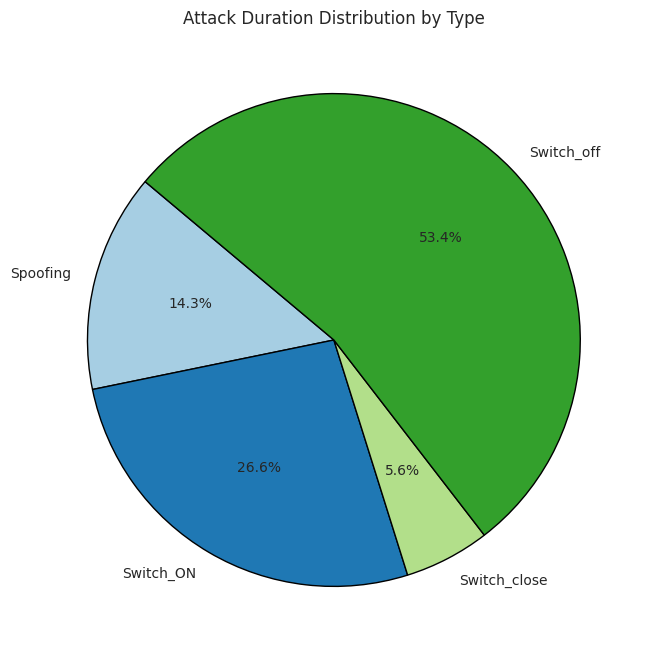

In [107]:
attack_durations = attack_summary.groupby('Attack_Type')['Duration'].sum()
attack_durations_seconds = attack_durations.dt.total_seconds()

plt.figure(figsize=(8, 8))
plt.pie(
    attack_durations_seconds,
    labels=attack_durations_seconds.index,
    autopct='%1.1f%%',
    startangle=140,
    colors=plt.cm.Paired.colors,
    wedgeprops={'edgecolor': 'black'}
)
plt.title('Attack Duration Distribution by Type')
plt.show()

In [108]:
def extract_specific_groups(df : pd.DataFrame, id_att : int = 1) -> list[pd.DataFrame]:
    if 'Label' not in df.columns:
        raise ValueError("The DataFrame must contain a 'Label' column.")

    df['Group_ID'] = (df['Label'] == id_att).astype(int).diff().fillna(0).ne(0).cumsum()

    attack_df = df[df['Label'] == id_att]

    attack_groups = [group_df.drop(columns='Group_ID') for _, group_df in attack_df.groupby('Group_ID')]

    return attack_groups

In [109]:
attack_dfs = extract_specific_groups(df, 1)

for attack_df in attack_dfs:
    print(f"Duration of the attack : {len(attack_df)} seconds")
    print(f"Attack type : {attack_df['Attack'].iloc[0]}")
    display(get_summary(attack_df).style.background_gradient(cmap='viridis_r', low=0.8))
    print("\n\n\n===========================================================\n")

Duration of the attack : 106 seconds
Attack type : Spoofing


,dtype,unique,missing,duplicates,min,max,avg,std dev
GMT +0,"datetime64[ns, UTC]",106,0,0,2019-07-20 07:07:00.005004800+00:00,2019-07-20 07:08:45.003005900+00:00,2019-07-20 07:07:52.503451136+00:00,nan
Attack,object,1,0,0,nan,nan,nan,nan
Label,int64,1,0,0,1.000000,1.000000,1.000000,0.000000
FIT 101,float64,1,0,0,0.000000,0.000000,0.000000,0.000000
LIT 101,float64,31,0,0,819.440552,821.285461,820.532245,0.385975
MV 101,int64,1,0,0,1.000000,1.000000,1.000000,0.000000
P1_STATE,int64,1,0,0,2.000000,2.000000,2.000000,0.000000
P101 Status,int64,1,0,0,1.000000,1.000000,1.000000,0.000000
AIT 201,float64,5,0,0,143.841324,144.321976,144.050211,0.082645
AIT 202,float64,25,0,0,9.073187,9.110997,9.090895,0.013117






Duration of the attack : 261 seconds
Attack type : Spoofing


,dtype,unique,missing,duplicates,min,max,avg,std dev
GMT +0,"datetime64[ns, UTC]",261,0,0,2019-07-20 07:13:27.003005900+00:00,2019-07-20 07:17:47.005004800+00:00,2019-07-20 07:15:37.003514112+00:00,nan
Attack,object,1,0,0,nan,nan,nan,nan
Label,int64,1,0,0,1.000000,1.000000,1.000000,0.000000
FIT 101,float64,1,0,0,0.000000,0.000000,0.000000,0.000000
LIT 101,float64,47,0,0,819.087300,821.442444,820.054931,0.532558
MV 101,int64,1,0,0,1.000000,1.000000,1.000000,0.000000
P1_STATE,int64,1,0,0,2.000000,2.000000,2.000000,0.000000
P101 Status,int64,1,0,0,1.000000,1.000000,1.000000,0.000000
AIT 201,float64,6,0,0,144.001541,144.193800,144.061208,0.050078
AIT 202,float64,66,0,0,8.986030,9.038900,9.006753,0.016224






Duration of the attack : 230 seconds
Attack type : Switch_ON


,dtype,unique,missing,duplicates,min,max,avg,std dev
GMT +0,"datetime64[ns, UTC]",230,0,0,2019-07-20 07:25:13.003005900+00:00,2019-07-20 07:29:02.002014100+00:00,2019-07-20 07:27:07.503417600+00:00,nan
Attack,object,1,0,0,nan,nan,nan,nan
Label,int64,1,0,0,1.000000,1.000000,1.000000,0.000000
FIT 101,float64,1,0,0,0.000000,0.000000,0.000000,0.000000
LIT 101,float64,203,0,0,619.958069,681.349365,650.267847,18.898584
MV 101,int64,1,0,0,1.000000,1.000000,1.000000,0.000000
P1_STATE,int64,1,0,0,2.000000,2.000000,2.000000,0.000000
P101 Status,int64,1,0,0,2.000000,2.000000,2.000000,0.000000
AIT 201,float64,114,0,0,115.130737,143.841324,128.729116,9.043581
AIT 202,float64,89,0,0,9.193989,9.394899,9.312891,0.061555






Duration of the attack : 450 seconds
Attack type : Switch_ON


,dtype,unique,missing,duplicates,min,max,avg,std dev
GMT +0,"datetime64[ns, UTC]",450,0,0,2019-07-20 07:37:19.002014100+00:00,2019-07-20 07:44:48.004013+00:00,2019-07-20 07:41:03.503306496+00:00,nan
Attack,object,1,0,0,nan,nan,nan,nan
Label,int64,1,0,0,1.000000,1.000000,1.000000,0.000000
FIT 101,float64,87,0,0,0.000000,4.397079,3.184601,1.934148
LIT 101,float64,408,0,0,495.605316,619.565552,547.699141,35.523409
MV 101,int64,3,0,0,0.000000,2.000000,1.635556,0.589876
P1_STATE,int64,1,0,0,2.000000,2.000000,2.000000,0.000000
P101 Status,int64,1,0,0,2.000000,2.000000,2.000000,0.000000
AIT 201,float64,74,0,0,116.412460,127.851830,121.124213,3.955591
AIT 202,float64,146,0,0,9.113561,9.304538,9.229863,0.047201






Duration of the attack : 144 seconds
Attack type : Switch_close


,dtype,unique,missing,duplicates,min,max,avg,std dev
GMT +0,"datetime64[ns, UTC]",144,0,0,2019-07-20 07:52:25.004013+00:00,2019-07-20 07:54:48.004013+00:00,2019-07-20 07:53:36.502803712+00:00,nan
Attack,object,1,0,0,nan,nan,nan,nan
Label,int64,1,0,0,1.000000,1.000000,1.000000,0.000000
FIT 101,float64,1,0,0,0.000000,0.000000,0.000000,0.000000
LIT 101,float64,34,0,0,819.990100,821.678000,820.990515,0.384094
MV 101,int64,1,0,0,1.000000,1.000000,1.000000,0.000000
P1_STATE,int64,1,0,0,2.000000,2.000000,2.000000,0.000000
P101 Status,int64,1,0,0,1.000000,1.000000,1.000000,0.000000
AIT 201,float64,6,0,0,128.140213,128.460648,128.289749,0.053592
AIT 202,float64,31,0,0,9.126698,9.177967,9.157809,0.018557






Duration of the attack : 1362 seconds
Attack type : Switch_off


,dtype,unique,missing,duplicates,min,max,avg,std dev
GMT +0,"datetime64[ns, UTC]",1362,0,0,2019-07-20 08:01:06.002014100+00:00,2019-07-20 08:23:47.002014100+00:00,2019-07-20 08:12:26.504176128+00:00,nan
Attack,object,1,0,0,nan,nan,nan,nan
Label,int64,1,0,0,1.000000,1.000000,1.000000,0.000000
FIT 101,float64,1,0,0,0.000000,0.000000,0.000000,0.000000
LIT 101,float64,54,0,0,819.126500,821.756500,820.633086,0.492446
MV 101,int64,1,0,0,1.000000,1.000000,1.000000,0.000000
P1_STATE,int64,1,0,0,2.000000,2.000000,2.000000,0.000000
P101 Status,int64,1,0,0,1.000000,1.000000,1.000000,0.000000
AIT 201,float64,6,0,0,128.460648,128.652908,128.492221,0.030925
AIT 202,float64,327,0,0,8.781275,9.024160,8.882802,0.069742


In [110]:
benign_dfs = extract_specific_groups(df, 0)

for benign_df in benign_dfs:
    print(f"Duration of the benign time before an attack : {len(benign_df)} seconds")
    display(get_summary(benign_df).style.background_gradient(cmap='viridis_r', low=0.8))
    print("\n\n\n===========================================================\n")

Duration of the benign time before an attack : 9416 seconds


,dtype,unique,missing,duplicates,min,max,avg,std dev
GMT +0,"datetime64[ns, UTC]",9416,0,0,2019-07-20 04:30:00+00:00,2019-07-20 07:06:59.002014100+00:00,2019-07-20 05:48:30.549966848+00:00,nan
Attack,object,1,0,0,nan,nan,nan,nan
Label,int64,1,0,0,0.000000,0.000000,0.000000,0.000000
FIT 101,float64,253,0,0,0.000000,4.402524,0.913527,1.771441
LIT 101,float64,3508,0,0,491.169769,825.092957,731.848196,112.580581
MV 101,int64,3,0,0,0.000000,2.000000,1.195412,0.416143
P1_STATE,int64,2,0,0,2.000000,3.000000,2.098131,0.297507
P101 Status,int64,2,0,0,1.000000,2.000000,1.366185,0.481787
AIT 201,float64,73,0,0,142.207123,146.821335,143.807908,0.533557
AIT 202,float64,1081,0,0,8.976096,9.490067,9.269068,0.137083






Duration of the benign time before an attack : 281 seconds


,dtype,unique,missing,duplicates,min,max,avg,std dev
GMT +0,"datetime64[ns, UTC]",281,0,0,2019-07-20 07:08:46.005004800+00:00,2019-07-20 07:13:26.002014100+00:00,2019-07-20 07:11:06.006289152+00:00,nan
Attack,object,1,0,0,nan,nan,nan,nan
Label,int64,1,0,0,0.000000,0.000000,0.000000,0.000000
FIT 101,float64,1,0,0,0.000000,0.000000,0.000000,0.000000
LIT 101,float64,41,0,0,819.597600,821.678000,820.524006,0.448483
MV 101,int64,1,0,0,1.000000,1.000000,1.000000,0.000000
P1_STATE,int64,1,0,0,2.000000,2.000000,2.000000,0.000000
P101 Status,int64,1,0,0,1.000000,1.000000,1.000000,0.000000
AIT 201,float64,11,0,0,143.841324,144.257889,144.044532,0.063547
AIT 202,float64,75,0,0,9.029928,9.090170,9.055341,0.017265






Duration of the benign time before an attack : 445 seconds


,dtype,unique,missing,duplicates,min,max,avg,std dev
GMT +0,"datetime64[ns, UTC]",445,0,0,2019-07-20 07:17:48.003005900+00:00,2019-07-20 07:25:12.003005900+00:00,2019-07-20 07:21:30.004222208+00:00,nan
Attack,object,1,0,0,nan,nan,nan,nan
Label,int64,1,0,0,0.000000,0.000000,0.000000,0.000000
FIT 101,float64,1,0,0,0.000000,0.000000,0.000000,0.000000
LIT 101,float64,428,0,0,624.236633,820.618164,726.473374,59.412591
MV 101,int64,1,0,0,1.000000,1.000000,1.000000,0.000000
P1_STATE,int64,1,0,0,2.000000,2.000000,2.000000,0.000000
P101 Status,int64,2,0,0,1.000000,2.000000,1.979775,0.140927
AIT 201,float64,28,0,0,143.488846,146.276600,144.026598,0.431578
AIT 202,float64,104,0,0,8.982184,9.409639,9.358941,0.109867






Duration of the benign time before an attack : 496 seconds


,dtype,unique,missing,duplicates,min,max,avg,std dev
GMT +0,"datetime64[ns, UTC]",496,0,0,2019-07-20 07:29:03.004013+00:00,2019-07-20 07:37:18.002014100+00:00,2019-07-20 07:33:10.503325696+00:00,nan
Attack,object,1,0,0,nan,nan,nan,nan
Label,int64,1,0,0,0.000000,0.000000,0.000000,0.000000
FIT 101,float64,1,0,0,0.000000,0.000000,0.000000,0.000000
LIT 101,float64,372,0,0,545.220800,685.549438,592.934515,47.503530
MV 101,int64,1,0,0,1.000000,1.000000,1.000000,0.000000
P1_STATE,int64,1,0,0,2.000000,2.000000,2.000000,0.000000
P101 Status,int64,2,0,0,1.000000,2.000000,1.616935,0.486625
AIT 201,float64,30,0,0,113.849014,116.732887,116.273692,0.446210
AIT 202,float64,80,0,0,9.119969,9.201679,9.178190,0.023358






Duration of the benign time before an attack : 456 seconds


,dtype,unique,missing,duplicates,min,max,avg,std dev
GMT +0,"datetime64[ns, UTC]",456,0,0,2019-07-20 07:44:49.003005900+00:00,2019-07-20 07:52:24.002014100+00:00,2019-07-20 07:48:36.503184896+00:00,nan
Attack,object,1,0,0,nan,nan,nan,nan
Label,int64,1,0,0,0.000000,0.000000,0.000000,0.000000
FIT 101,float64,65,0,0,0.000000,4.403484,2.253492,2.180326
LIT 101,float64,311,0,0,620.154300,822.855600,766.477760,66.197082
MV 101,int64,3,0,0,0.000000,2.000000,1.464912,0.537472
P1_STATE,int64,1,0,0,2.000000,2.000000,2.000000,0.000000
P101 Status,int64,1,0,0,1.000000,1.000000,1.000000,0.000000
AIT 201,float64,10,0,0,127.851830,128.460648,128.313711,0.068654
AIT 202,float64,120,0,0,9.168995,9.319597,9.233891,0.034369






Duration of the benign time before an attack : 377 seconds


,dtype,unique,missing,duplicates,min,max,avg,std dev
GMT +0,"datetime64[ns, UTC]",377,0,0,2019-07-20 07:54:49.002014100+00:00,2019-07-20 08:01:05.003005900+00:00,2019-07-20 07:57:57.002706176+00:00,nan
Attack,object,1,0,0,nan,nan,nan,nan
Label,int64,1,0,0,0.000000,0.000000,0.000000,0.000000
FIT 101,float64,1,0,0,0.000000,0.000000,0.000000,0.000000
LIT 101,float64,40,0,0,819.440552,821.560242,820.720506,0.392290
MV 101,int64,1,0,0,1.000000,1.000000,1.000000,0.000000
P1_STATE,int64,1,0,0,2.000000,2.000000,2.000000,0.000000
P101 Status,int64,1,0,0,1.000000,1.000000,1.000000,0.000000
AIT 201,float64,9,0,0,128.268387,128.620865,128.390526,0.066176
AIT 202,float64,101,0,0,9.024481,9.142400,9.080216,0.030436






Duration of the benign time before an attack : 972 seconds


,dtype,unique,missing,duplicates,min,max,avg,std dev
GMT +0,"datetime64[ns, UTC]",972,0,0,2019-07-20 08:23:48+00:00,2019-07-20 08:39:59.004013+00:00,2019-07-20 08:31:53.502991616+00:00,nan
Attack,object,1,0,0,nan,nan,nan,nan
Label,int64,1,0,0,0.000000,0.000000,0.000000,0.000000
FIT 101,float64,17,0,0,0.000000,4.323736,0.049114,0.420290
LIT 101,float64,743,0,0,491.169769,821.599500,695.014946,110.512380
MV 101,int64,3,0,0,0.000000,2.000000,1.004115,0.150466
P1_STATE,int64,1,0,0,2.000000,2.000000,2.000000,0.000000
P101 Status,int64,2,0,0,1.000000,2.000000,1.762346,0.425865
AIT 201,float64,31,0,0,128.364517,133.619583,130.894838,1.350980
AIT 202,float64,165,0,0,8.768457,9.326006,9.170254,0.231752


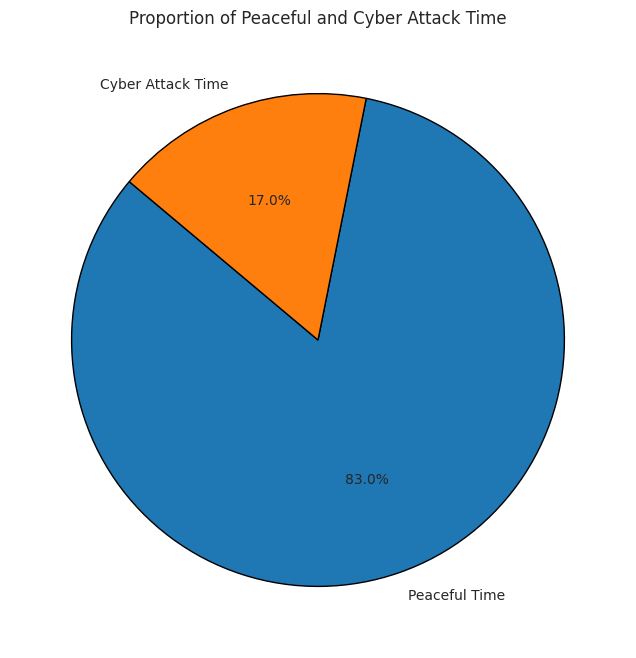

In [114]:
peaceful_duration = len(df[df['Label'] == 0])
attack_duration = len(df[df['Label'] == 1])

labels = ['Peaceful Time', 'Cyber Attack Time']
sizes = [peaceful_duration, attack_duration]
colors = ['#1f77b4', '#ff7f0e']

plt.figure(figsize=(8, 8))
plt.pie(
    sizes,
    labels=labels,
    autopct='%1.1f%%',
    startangle=140,
    colors=colors,
    wedgeprops={'edgecolor': 'black'}
)
plt.title('Proportion of Peaceful and Cyber Attack Time')
plt.savefig("time_repartition_dataset.png")
plt.show()

# ***SWaT System Overview***

* P1: Raw Water Storage - Model-Based Monitoring System
    * MV101
    * FIT101
    * LIT101
    * T101
    * P101
    * P102
* P2: Chemical Dosing - Data-Driven / Model-Based Monitoring System
    * FIT201
    * AIT201
    * AIT202
    * AIT203
    * MV201
    * P201
    * P202
    * P203
    * P204
    * P205
    * P206
    * LS201
    * LS202
    * LSL203
    * LSLL203
* P3: Ultra-filtration (UF) - Model-Based Monitoring System
    * LIT301
    * FIT301
    * DPIT301
    * MV301
    * MV302
    * MV304
    * P301
    * P302
    * PSH301
    * DPSH301
* P4: Dechlorination - Model-Based Monitoring System
    * LIT401
    * FIT401
    * AIT401
    * AIT402
    * P401
    * P402
    * P403
    * P404
    * UV401
    * LS401
* P5: Reverse Osmosis (RO) - Data-Driven Monitoring System
    * FIT501
    * FIT502
    * FIT503
    * FIT504
    * AIT501
    * AIT502
    * AIT503
    * AIT504
    * PIT501
    * PIT502
    * PIT503
    * P501
    * P502
    * MV501
    * MV502
    * MV503
    * MV504
    * PSH501
    * PSL501
* P6: RO Permeate transfer, UF backwash - Data-Driven Monitoring System
    * FIT601
    * P601
    * P602
    * LSH601
    * LSL601
    * LSH602
    * LSL602
    * LSH603
    * LSL603

In [72]:
stamps = df.filter(regex='GMT.*').copy()
attacks = df.filter(regex='Attack').copy()
labels = df.filter(regex='Label').copy()
p1_ = df.filter(regex='P1.*|.*10.*').copy()
p2_ = df.filter(regex='P2.*|.*20.*').copy()
p3_ = df.filter(regex='P3.*|.*30.*').copy()
p4_ = df.filter(regex='P4.*|.*40.*').copy()
p5_ = df.filter(regex='P5.*|.*50.*').copy()
p6_ = df.filter(regex='P6.*|.*60.*').copy()

In [88]:
def check_sum_columns(ref: pd.DataFrame, list_df : list[pd.DataFrame]) -> bool | None:
    if ref is None or list_df is None:
        return None
    cumsum = 0
    for df_ in list_df:
        cumsum += deu.get_nb_of_dimensions(df_)
    return cumsum == deu.get_nb_of_dimensions(ref)

check_sum_columns(df, [stamps, attacks, labels, p1_, p2_, p3_, p4_, p5_, p6_])

AttributeError: 'dict_keys' object has no attribute 'columns'

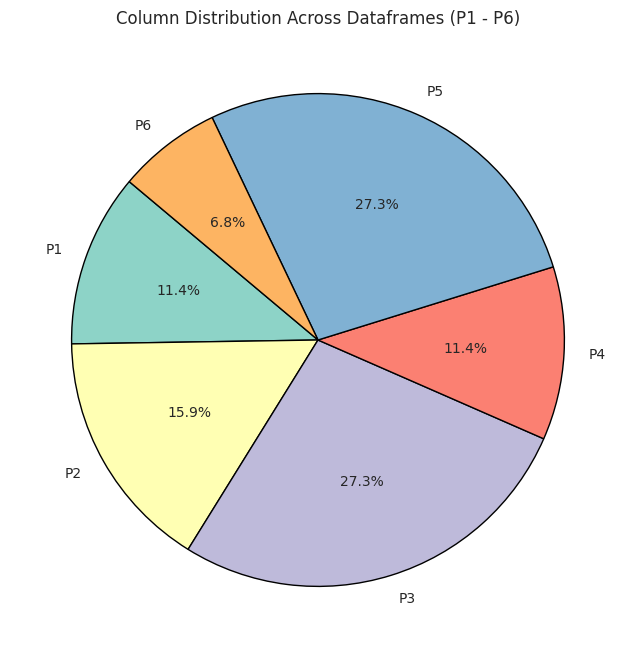

In [74]:
column_counts = {
    'P1': p1_.shape[1],
    'P2': p2_.shape[1],
    'P3': p3_.shape[1],
    'P4': p4_.shape[1],
    'P5': p5_.shape[1],
    'P6': p6_.shape[1]
}

labels = column_counts.keys()
sizes = column_counts.values()

plt.figure(figsize=(8, 8))
plt.pie(
    sizes,
    labels=labels,
    autopct='%1.1f%%',
    startangle=140,
    colors=plt.cm.Set3.colors,
    wedgeprops={'edgecolor': 'black'}
)

plt.title('Column Distribution Across Dataframes (P1 - P6)')
plt.savefig("swat_column_distribution.png")
plt.show()

In [75]:
# Utils

def prepare_dfs(list_df : list[pd.DataFrame]) -> pd.DataFrame:
    df = pd.concat(list_df, axis=1).copy()


    for column in df.columns:
        df[column] = df[column].map(
            lambda x: float(str(x).replace(',', '.')) 
            if isinstance(x, str) and x.replace(',', '').replace('.', '', 1).isdigit() 
            else x
        )
    df = df.apply(pd.to_numeric, errors='coerce')
    # print(df)
    df.fillna(value=0, inplace=True)
    return df


def scale_data(df : pd.DataFrame) -> np.ndarray:
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df)

    print(f'Scaled data shape: {scaled_data.shape}')

    return scaled_data


def pca_(scaled_data : np.ndarray, var_retention : float = 0.95) -> tuple[Any, Any]:
    pca = PCA(n_components=var_retention)
    pca_components = pca.fit_transform(scaled_data)

    print(f'PCA Components: {pca_components.shape}')

    return pca_components, pca


def metrics_pca(pca : Any, scaled_data : np.ndarray) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    reconstructed = pca.inverse_transform(pca_components)
    reconstruction_error = np.mean((scaled_data - reconstructed) ** 2, axis=1)

    plt.plot(reconstruction_error)

    threshold_pca = np.mean(reconstruction_error) + 3 * np.std(reconstruction_error)
    anomalies_pca = reconstruction_error > threshold_pca

    print(f'Number of anomalies: {np.sum(anomalies_pca)}')

    return reconstruction_error, threshold_pca, anomalies_pca


def metrics_iso_forest(scaled_data : np.ndarray, contamination : float = 0.01, random_state : int = 42) -> tuple[np.ndarray, np.ndarray]:
    iso_forest = IsolationForest(contamination=contamination, random_state=random_state)

    anomaly_scores = iso_forest.fit_predict(scaled_data)
    anomalies_iforest = anomaly_scores == -1

    return anomaly_scores, anomalies_iforest


def metrics_lof(scaled_data : np.ndarray, contamination : float = 0.01, n_neighbors : int = 20) -> tuple[np.ndarray, np.ndarray]:
    loc_out_factor = LocalOutlierFactor(n_neighbors=n_neighbors, contamination=contamination)

    anomaly_scores = loc_out_factor.fit_predict(scaled_data)
    anomalies_lof = anomaly_scores == -1

    return anomaly_scores, anomalies_lof


def plot_reconstruction_error():
    plt.figure(figsize=(12, 6))
    plt.plot(reconstruction_error, label='Reconstruction Error', color='blue')
    plt.axhline(threshold_pca, color='red', linestyle='--', label='Anomaly Threshold')
    plt.title('Reconstruction Error with Anomaly Threshold')
    plt.xlabel('Time Index')
    plt.ylabel('Error')
    plt.legend()
    plt.show()


def plot_heatmap(df : pd.DataFrame) -> None:
    plt.figure(figsize=(30, 15))
    data = df[df['Anomaly'] == True].iloc[:, :-3].apply(pd.to_numeric, errors='coerce').fillna(0)
    data = data.select_dtypes(include=[np.number])
    sns.heatmap(data.T, cmap='coolwarm', cbar=True)
    plt.title('Heatmap of Sensors During Anomalies')
    plt.xlabel('Time Index')
    plt.ylabel('Sensors')
    plt.show()


def check_common_anomalies_3methods(anomalies_pca: np.ndarray, anomalies_iforest: np.ndarray, anomalies_lof: np.ndarray) -> None:
    common_anomalies_all = anomalies_pca & anomalies_iforest & anomalies_lof
    common_anomalies_pca_iforest = anomalies_pca & anomalies_iforest
    common_anomalies_pca_lof = anomalies_pca & anomalies_lof
    common_anomalies_iforest_lof = anomalies_iforest & anomalies_lof

    print(f"Total common anomalies detected by all methods: {np.sum(common_anomalies_all)}")
    print(f"Total common anomalies detected by PCA and Isolation Forest: {np.sum(common_anomalies_pca_iforest)}")
    print(f"Total common anomalies detected by PCA and Local Outlier Factor: {np.sum(common_anomalies_pca_lof)}")
    print(f"Total common anomalies detected by Isolation Forest and Local Outlier Factor: {np.sum(common_anomalies_iforest_lof)}")


def evaluate_metrics(y_true, y_pred):
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    mcc = matthews_corrcoef(y_true, y_pred)
    balanced_acc = balanced_accuracy_score(y_true, y_pred)
    auc_prc = roc_auc_score(y_true, y_pred)

    return {
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1,
        "MCC": mcc,
        "Balanced Accuracy": balanced_acc,
        "AUC-PRC": auc_prc
    }

# ***Multi Stage Multi Point (MSMP)***
Targets multiple sensors at multiple points in time.

In [76]:
p1_6 = prepare_dfs([p1_, p2_, p3_, p4_, p5_, p6_])
p1_6

,FIT 101,LIT 101,MV 101,P1_STATE,P101 Status,AIT 201,AIT 202,AIT 203,FIT 201,MV201,P203 Status,P205 Status,AIT 301,AIT 302,AIT 303,DPIT 301,FIT 301,LIT 301,MV 301,MV 302,MV 303,MV 304,P3_STATE,P301 Status,AIT 402,FIT 401,LIT 401,P401 Status,UV401,AIT 501,AIT 502,AIT 503,AIT 504,FIT 501,FIT 502,FIT 503,FIT 504,MV 501,PIT 501,PIT 502,PIT 503,FIT 601,LSH 601,P601 Status
0,0.000000,729.865800,1,3,2,142.527557,9.293002,198.077423,2.335437,2,2,2,8.522921,256.431274,143.158966,1.190857,0.000512,730.702100,1,1,1,1,99,1,87.951805,0.781740,1000.628050,2,2,7.489618,147.398100,1016.27789,46.065113,0.781594,0.310362,0.623628,0.213432,2,167.601257,2.963509,119.921173,0.00032,1,1
1,0.000000,729.434000,1,3,2,142.527557,9.293002,198.385025,2.335437,2,2,2,8.522921,256.431274,143.158966,1.190857,0.000512,730.902344,1,1,1,1,99,1,87.823630,0.782380,1000.551150,2,2,7.489618,147.398100,1016.27789,45.757500,0.782235,0.315102,0.623628,0.212984,2,167.601257,2.963509,119.921173,0.00032,1,1
2,0.000000,729.120000,1,3,2,142.527557,9.293002,198.436300,2.335437,2,2,2,8.522921,256.431274,143.158966,1.190857,0.000512,732.344300,1,1,1,1,99,1,87.798004,0.783021,1000.282000,2,2,7.489618,147.398100,1016.27789,45.603690,0.782235,0.317023,0.623628,0.212984,2,167.601257,2.963509,119.921173,0.00032,1,1
3,0.000000,728.688200,1,3,2,142.527557,9.289157,198.667000,2.335437,2,2,2,8.522921,256.431274,143.158966,1.190857,0.000512,732.704800,1,1,1,1,99,1,87.695465,0.783021,1000.743410,2,2,7.489618,147.167389,1016.27789,45.603690,0.783133,0.308057,0.623628,0.212792,2,167.601257,2.963509,119.921173,0.00032,1,1
4,0.000000,727.706900,1,3,2,142.527557,9.289157,198.897720,2.335437,2,2,2,8.522921,256.431274,143.158966,1.190857,0.000512,732.744800,1,1,1,1,99,1,87.618560,0.781228,1000.397340,2,2,7.489618,147.090485,1016.27789,45.219173,0.783773,0.303446,0.623628,0.214009,2,167.601257,2.963509,119.921173,0.00032,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14991,4.200429,491.169769,2,2,2,131.408615,9.319918,257.703156,2.316086,2,2,2,8.744734,273.103271,134.227539,12.222293,1.718477,883.227051,1,2,1,1,7,2,3.691361,0.809271,961.868800,2,2,7.765830,63.752884,1016.21381,24.839785,0.809536,0.366594,0.607752,0.209909,2,158.773392,2.498959,113.784927,0.00032,1,1
14992,4.253915,491.405273,2,2,2,131.408615,9.317354,257.703156,2.314292,2,2,2,8.744734,273.103271,134.227539,12.222293,1.719373,883.227051,1,2,1,1,7,2,3.742630,0.809271,962.137939,2,2,7.765830,63.752884,1016.21381,24.839785,0.809536,0.374023,0.605960,0.209909,2,158.805435,2.498959,113.784927,0.00032,1,1
14993,4.303558,492.308100,2,2,2,131.408615,9.317354,257.703156,2.313651,2,2,2,8.744734,273.103271,134.227539,12.222293,1.719373,883.387268,1,2,1,1,7,2,3.742630,0.809271,962.637756,2,2,7.765830,63.752884,1016.21381,24.839785,0.809536,0.369156,0.605960,0.209909,2,158.853500,2.498959,113.784927,0.00032,1,1
14994,4.323736,492.465100,2,2,2,131.408615,9.316713,257.703156,2.313651,2,2,2,8.744734,273.103271,134.227539,12.222293,1.719373,883.908000,1,2,1,1,7,2,3.742630,0.808631,962.445557,2,2,7.765830,63.752884,1016.21381,24.839785,0.809536,0.357115,0.605960,0.209909,2,158.853500,2.498959,113.784927,0.00032,1,1


In [77]:
scaled_data = scale_data(p1_6)

Scaled data shape: (14996, 44)


## ***PCA***

In [78]:
pca_components, pca = pca_(scaled_data)

PCA Components: (14996, 17)


Number of anomalies: 54


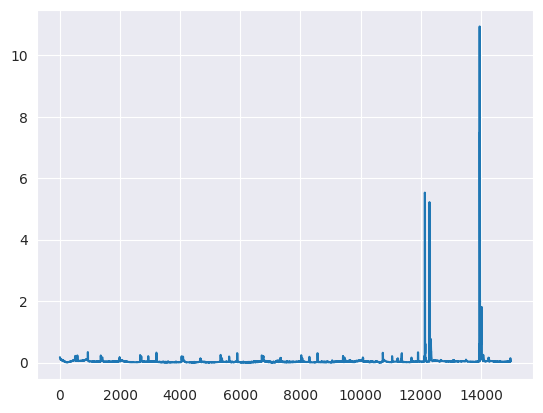

In [79]:
reconstruction_error, threshold_pca, anomalies_pca  = metrics_pca(pca, scaled_data)

## ***Isolation Forest***

In [80]:
anomaly_scores_iso, anomalies_iforest = metrics_iso_forest(scaled_data)

## ***Local Outlier Factor***

In [81]:
anomaly_scores_lof, anomalies_lof = metrics_lof(scaled_data)

## ***Combining Anomalies***

In [82]:
combined_anomalies = anomalies_pca | anomalies_iforest | anomalies_lof
combined_anomalies_p1_6_and = anomalies_pca & anomalies_iforest & anomalies_lof

In [83]:
p1_6['Anomaly'] = combined_anomalies
p1_6['Reconstruction_Error'] = reconstruction_error
p1_6['Isolation_Score'] = anomaly_scores_iso
p1_6['Lof_Score'] = anomaly_scores_lof

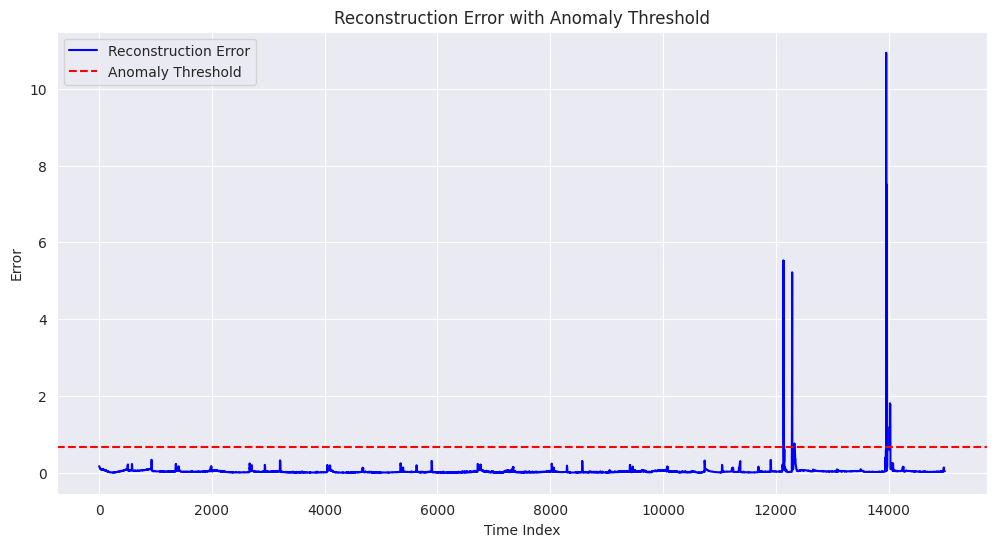

In [84]:
plot_reconstruction_error()

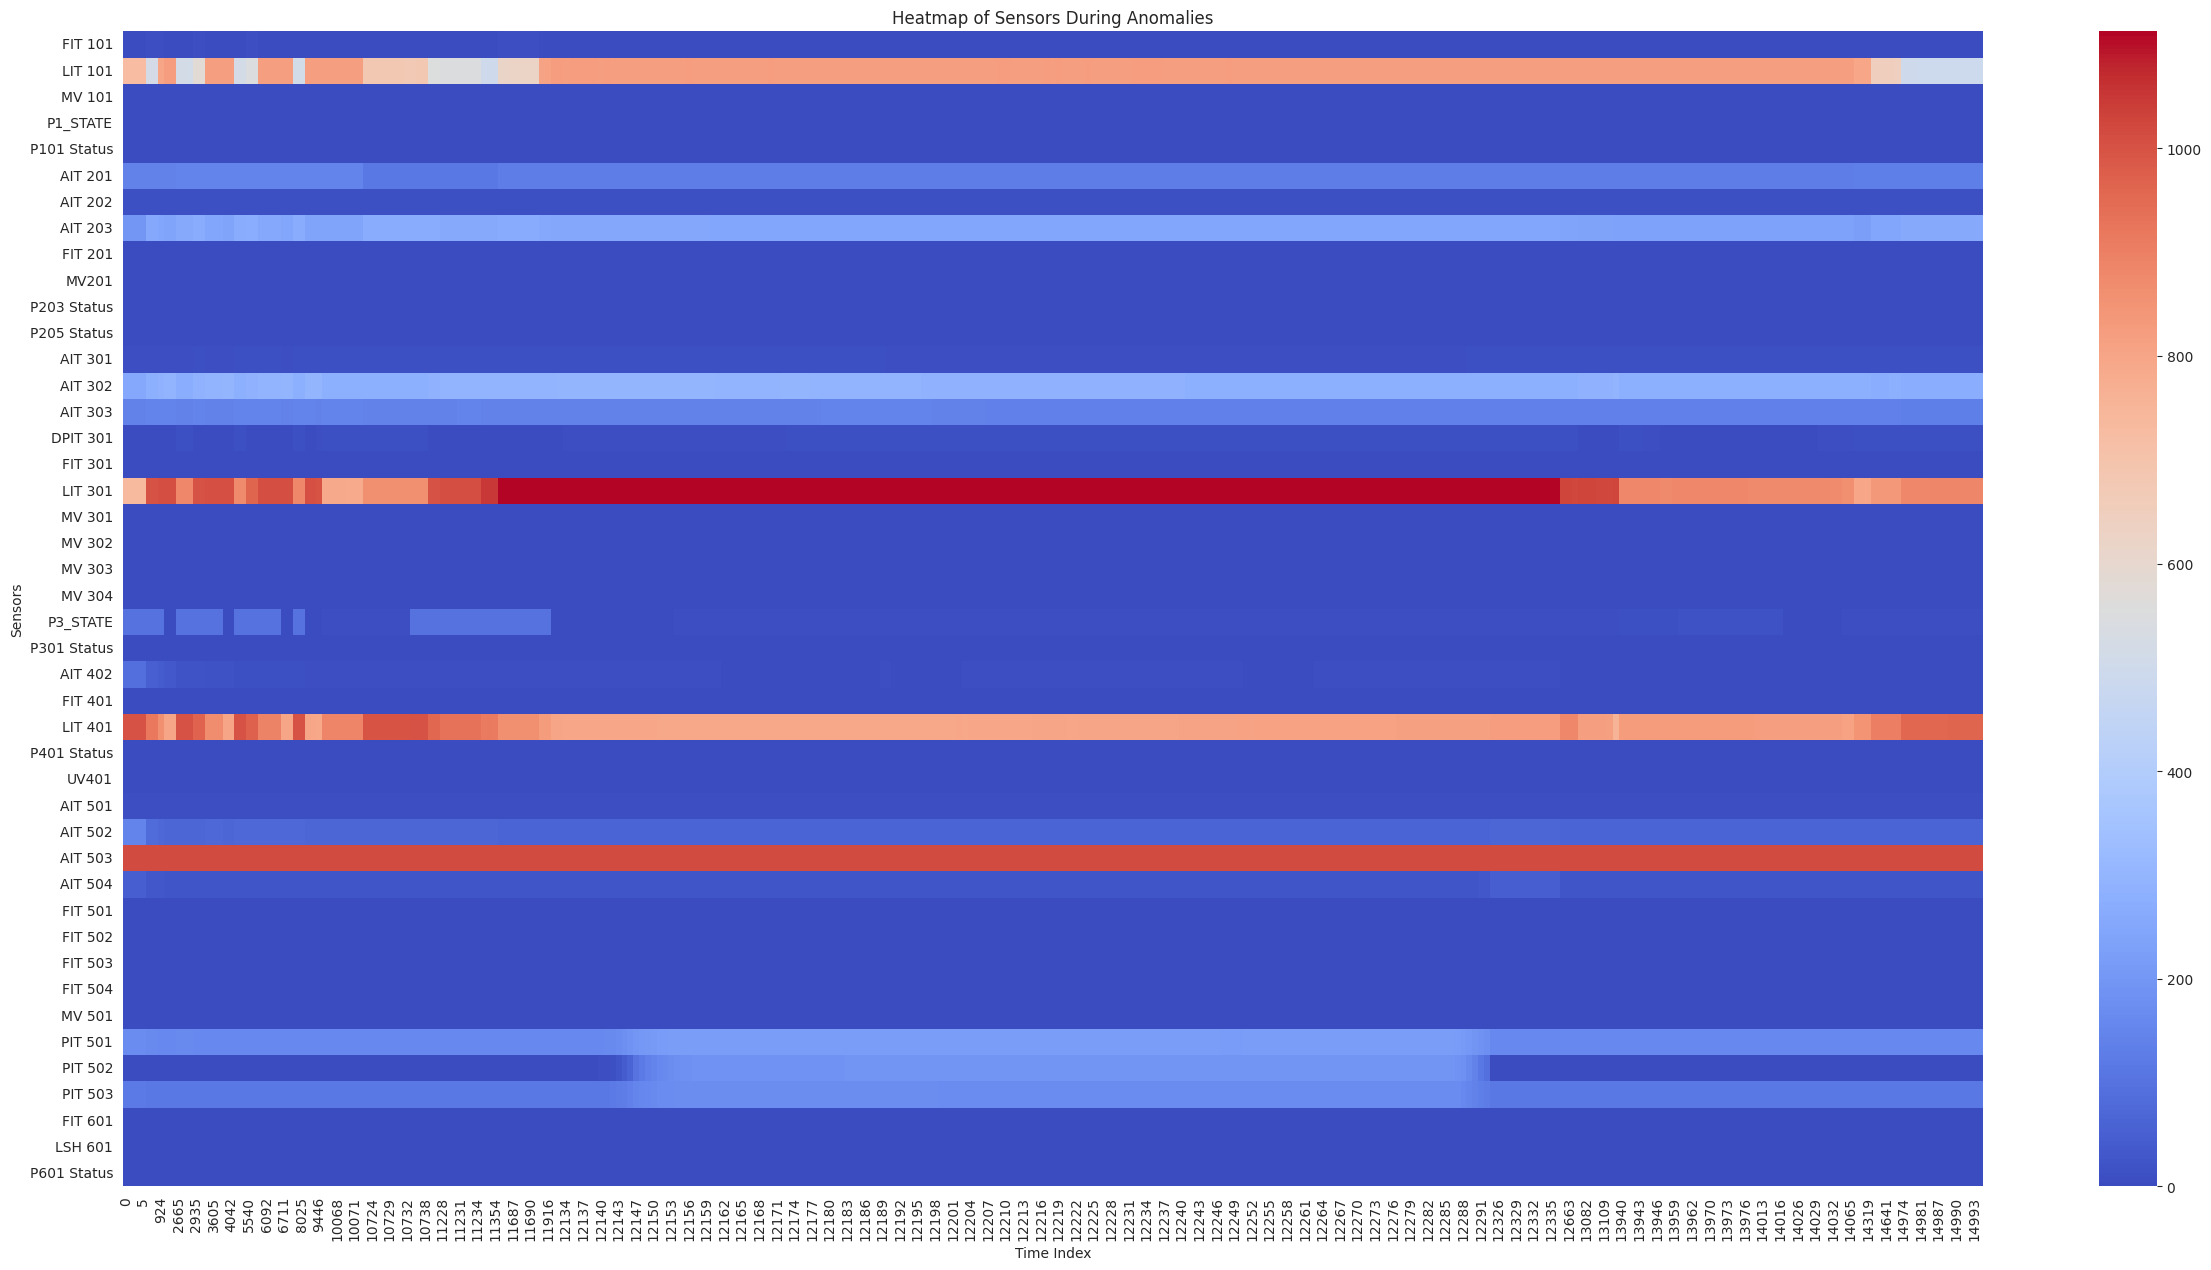

In [85]:
plot_heatmap(p1_6)

In [86]:
print(f"Total anomalies detected by PCA: {np.sum(anomalies_pca)}")
print(f"Total anomalies detected by Isolation Forest: {np.sum(anomalies_iforest)}")
print(f"Total anomalies detected by Local Outlier Factor: {np.sum(anomalies_lof)}\n\n")

check_common_anomalies_3methods(anomalies_pca, anomalies_iforest, anomalies_lof)

Total anomalies detected by PCA: 54
Total anomalies detected by Isolation Forest: 148
Total anomalies detected by Local Outlier Factor: 150


Total common anomalies detected by all methods: 6
Total common anomalies detected by PCA and Isolation Forest: 6
Total common anomalies detected by PCA and Local Outlier Factor: 28
Total common anomalies detected by Isolation Forest and Local Outlier Factor: 7


In [87]:
true_labels = prepare_dfs([labels])

print("Classification Report:")
print(classification_report(true_labels, p1_6['Anomaly']))

print("Confusion Matrix:")
cm = confusion_matrix(true_labels, p1_6['Anomaly'])
print(cm)

TypeError: cannot concatenate object of type '<class 'dict_keys'>'; only Series and DataFrame objs are valid

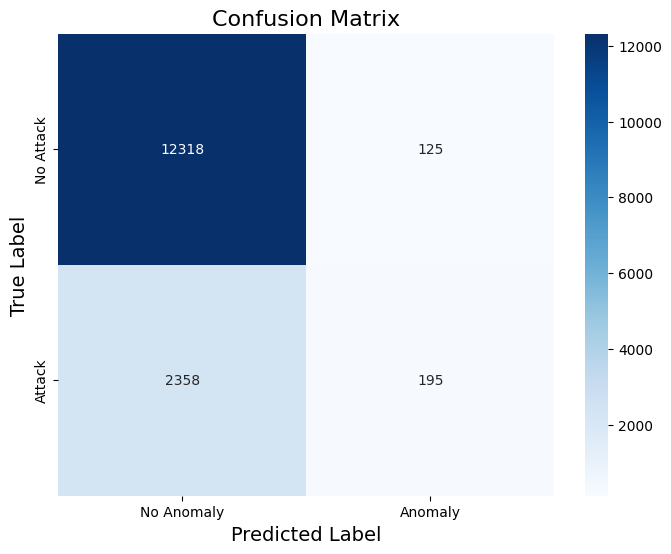

In [85]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Anomaly', 'Anomaly'], yticklabels=['No Attack', 'Attack'])
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.show()

In [86]:
metrics_pca_dict = evaluate_metrics(true_labels, anomalies_pca)
metrics_iso_forest_dict = evaluate_metrics(true_labels, anomalies_iforest)
metrics_lof_dict = evaluate_metrics(true_labels, anomalies_lof)

results = pd.DataFrame([metrics_pca_dict, metrics_iso_forest_dict, metrics_lof_dict],
                       index=["PCA", "Isolation Forest", "Local Outlier Factor"])

print(results)

                      Precision    Recall  F1-Score       MCC  \
PCA                    0.314815  0.006659  0.013042  0.023124   
Isolation Forest       0.913333  0.053662  0.101369  0.198732   
Local Outlier Factor   0.366667  0.021543  0.040696  0.052531   

                      Balanced Accuracy   AUC-PRC  
PCA                            0.501843  0.501843  
Isolation Forest               0.526309  0.526309  
Local Outlier Factor           0.506954  0.506954  


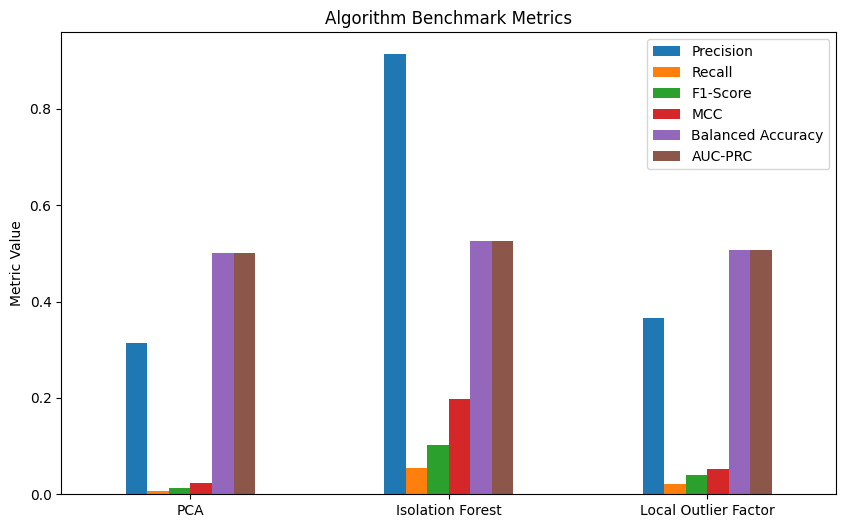

In [87]:
results.plot(kind='bar', figsize=(10, 6), title='Algorithm Benchmark Metrics')
plt.ylabel('Metric Value')
plt.xticks(rotation=0)
plt.legend(loc='upper right')
plt.show()

# ***Single Stage Multi Point (SSMP)***
Targets multiple sensors at a single point in time.

## ***Single Stage Multi Point (SSMP) - P1***

Scaled data shape: (14996, 5)
PCA Components: (14996, 4)
Number of anomalies: 105


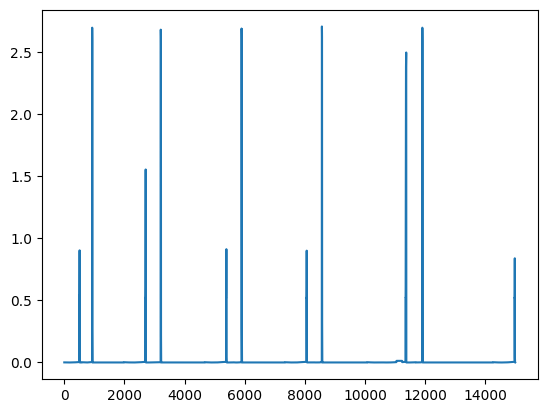

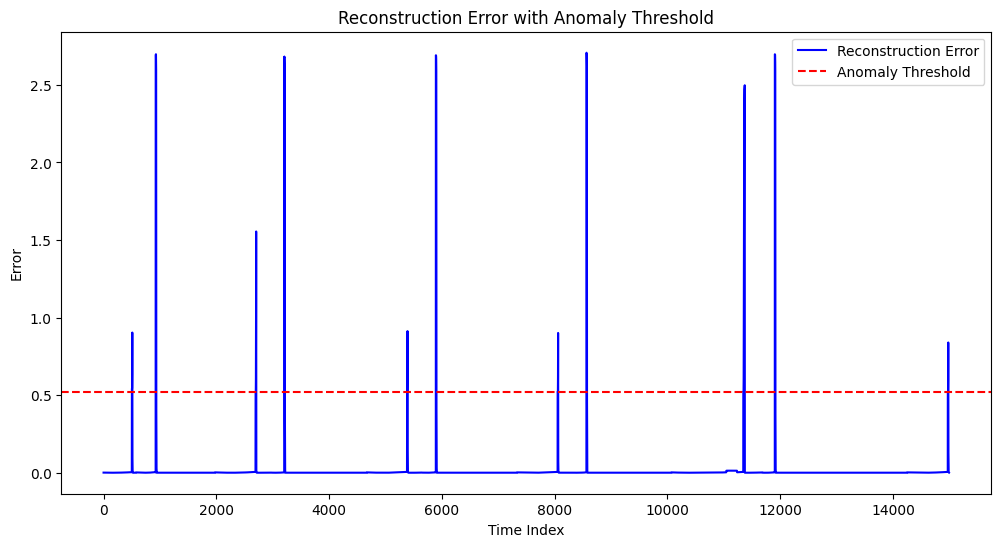

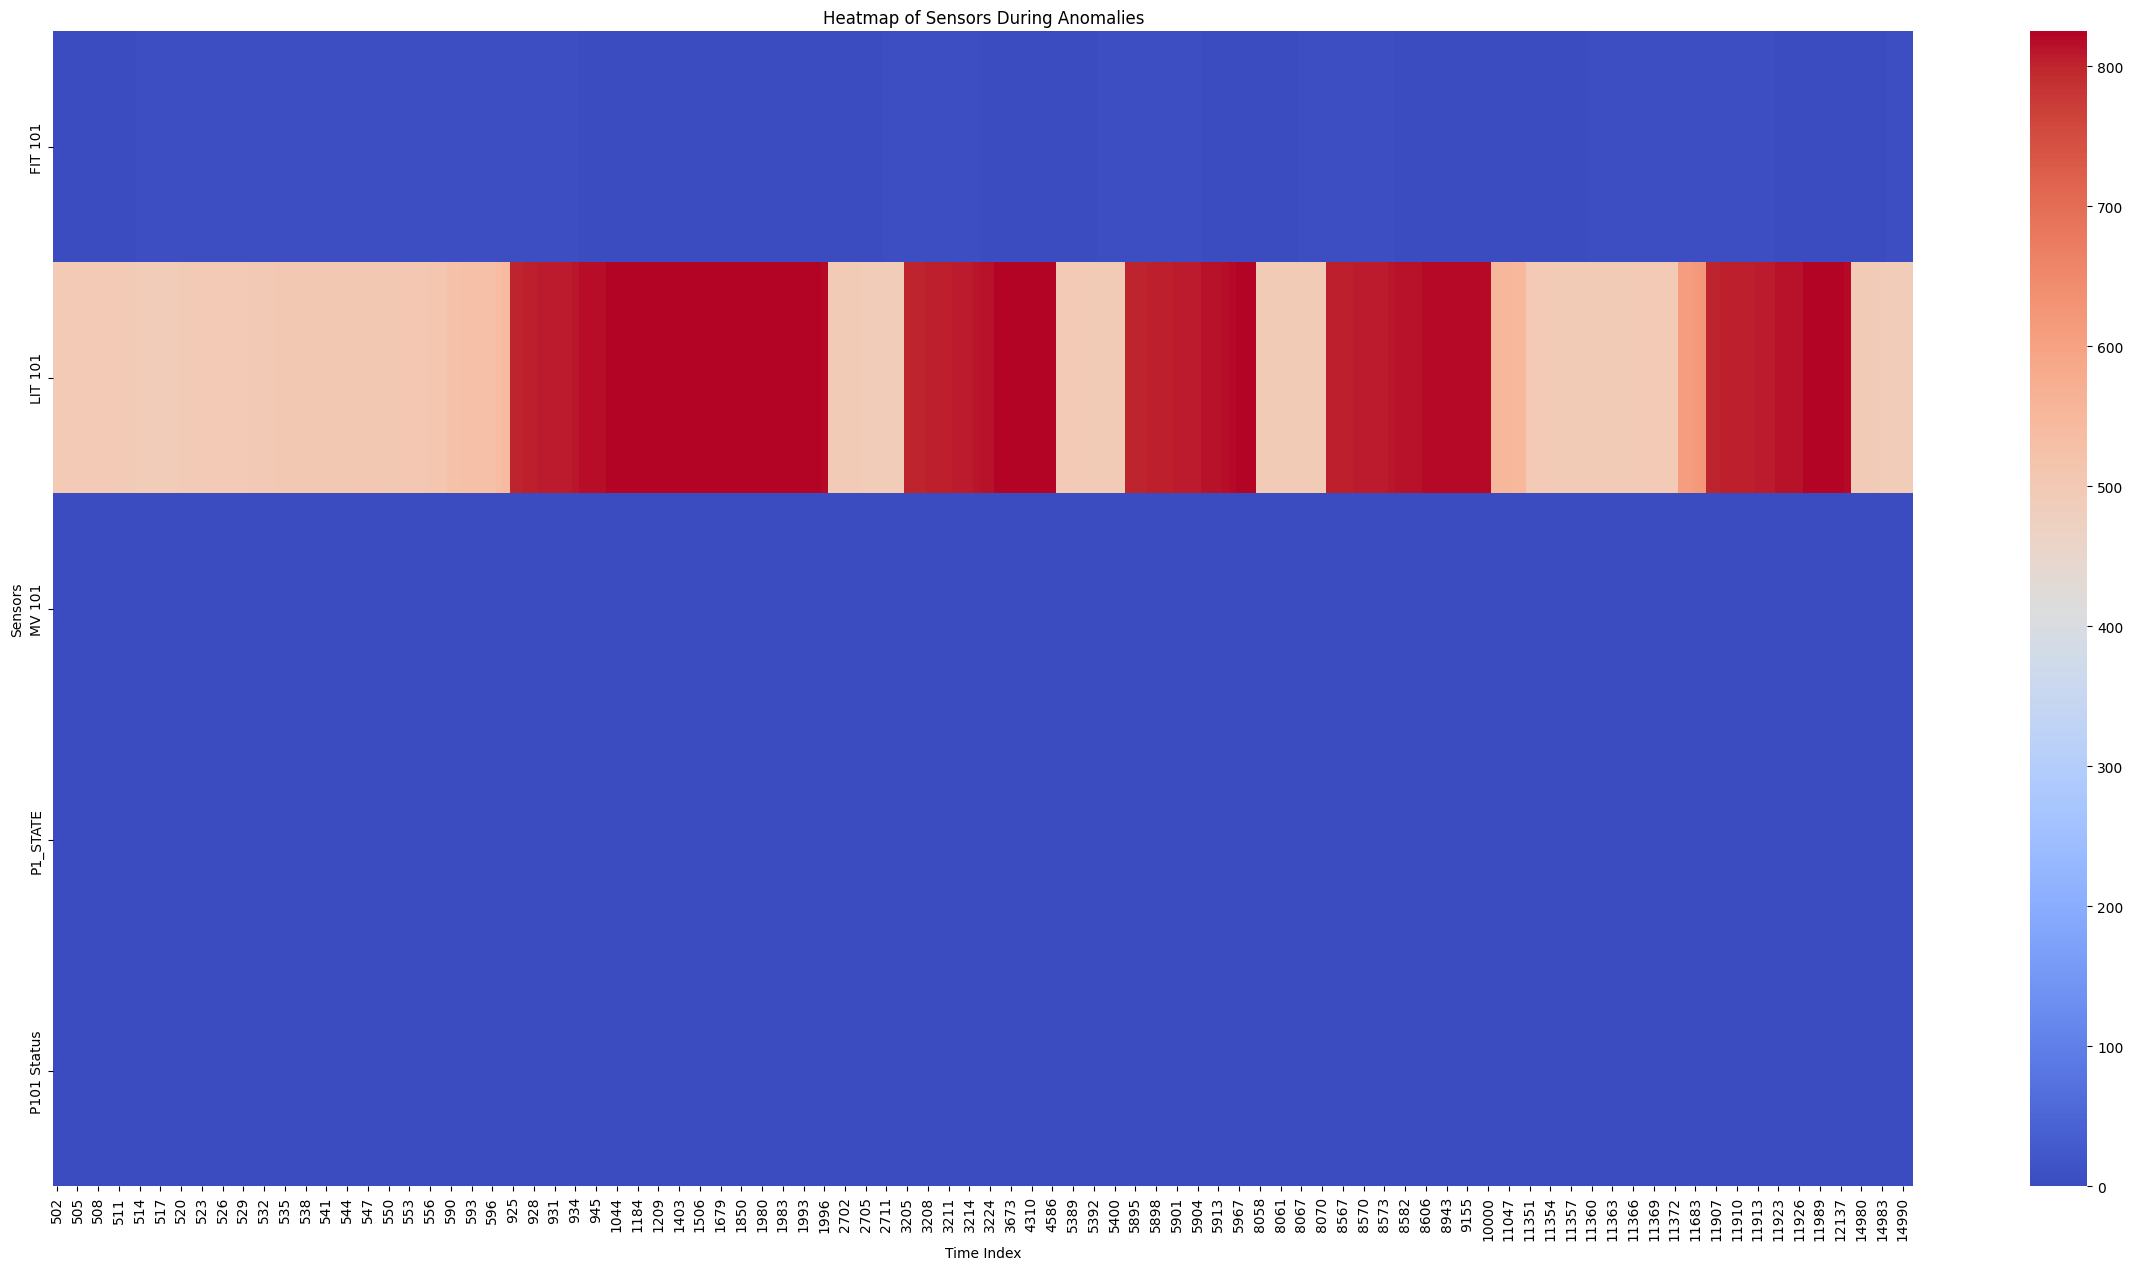

Total anomalies detected by PCA: 105
Total anomalies detected by Isolation Forest: 150
Total anomalies detected by Local Outlier Factor: 150


Total common anomalies detected by all methods: 32
Total common anomalies detected by PCA and Isolation Forest: 93
Total common anomalies detected by PCA and Local Outlier Factor: 33
Total common anomalies detected by Isolation Forest and Local Outlier Factor: 42


In [88]:
p1 = prepare_dfs([p1_])
scaled_data = scale_data(p1)

#### ***PCA***
pca_components, pca = pca_(scaled_data)
reconstruction_error, threshold_pca, anomalies_pca = metrics_pca(pca, scaled_data)

#### ***Isolation Forest***
anomaly_scores_iso, anomalies_iforest = metrics_iso_forest(scaled_data)

#### ***Local Outlier Factor***
anomaly_scores_lof, anomalies_lof = metrics_lof(scaled_data)

#### ***Combining Anomalies***
combined_anomalies = anomalies_pca | anomalies_iforest | anomalies_lof
combined_anomalies_p1_and = anomalies_pca & anomalies_iforest & anomalies_lof

p1['Anomaly'] = combined_anomalies
p1['Reconstruction_Error'] = reconstruction_error
p1['Isolation_Score'] = anomaly_scores_iso
p1['Lof_Score'] = anomaly_scores_lof

plot_reconstruction_error()
plot_heatmap(p1)

print(f"Total anomalies detected by PCA: {np.sum(anomalies_pca)}")
print(f"Total anomalies detected by Isolation Forest: {np.sum(anomalies_iforest)}")
print(f"Total anomalies detected by Local Outlier Factor: {np.sum(anomalies_lof)}\n\n")

check_common_anomalies_3methods(anomalies_pca, anomalies_iforest, anomalies_lof)

## ***Single Stage Multi Point (SSMP) - P2***

Scaled data shape: (14996, 7)
PCA Components: (14996, 3)
Number of anomalies: 191


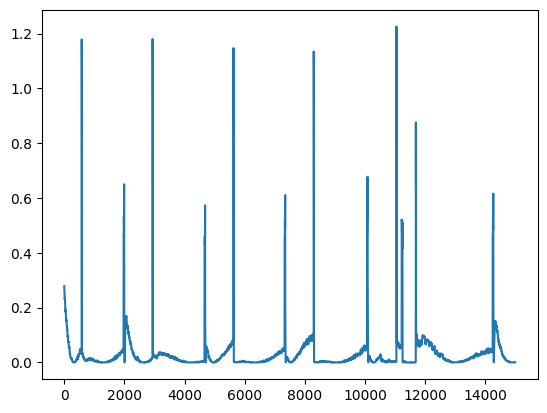

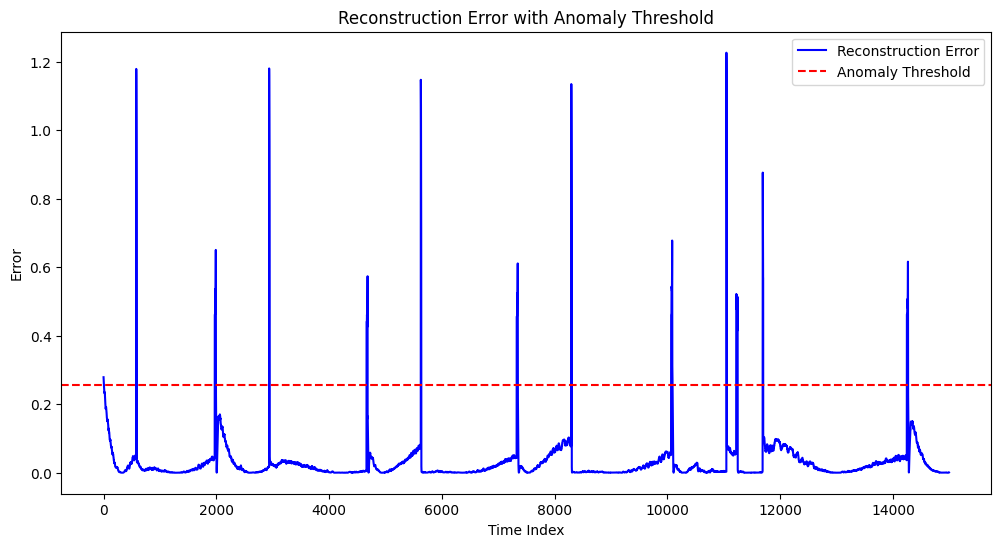

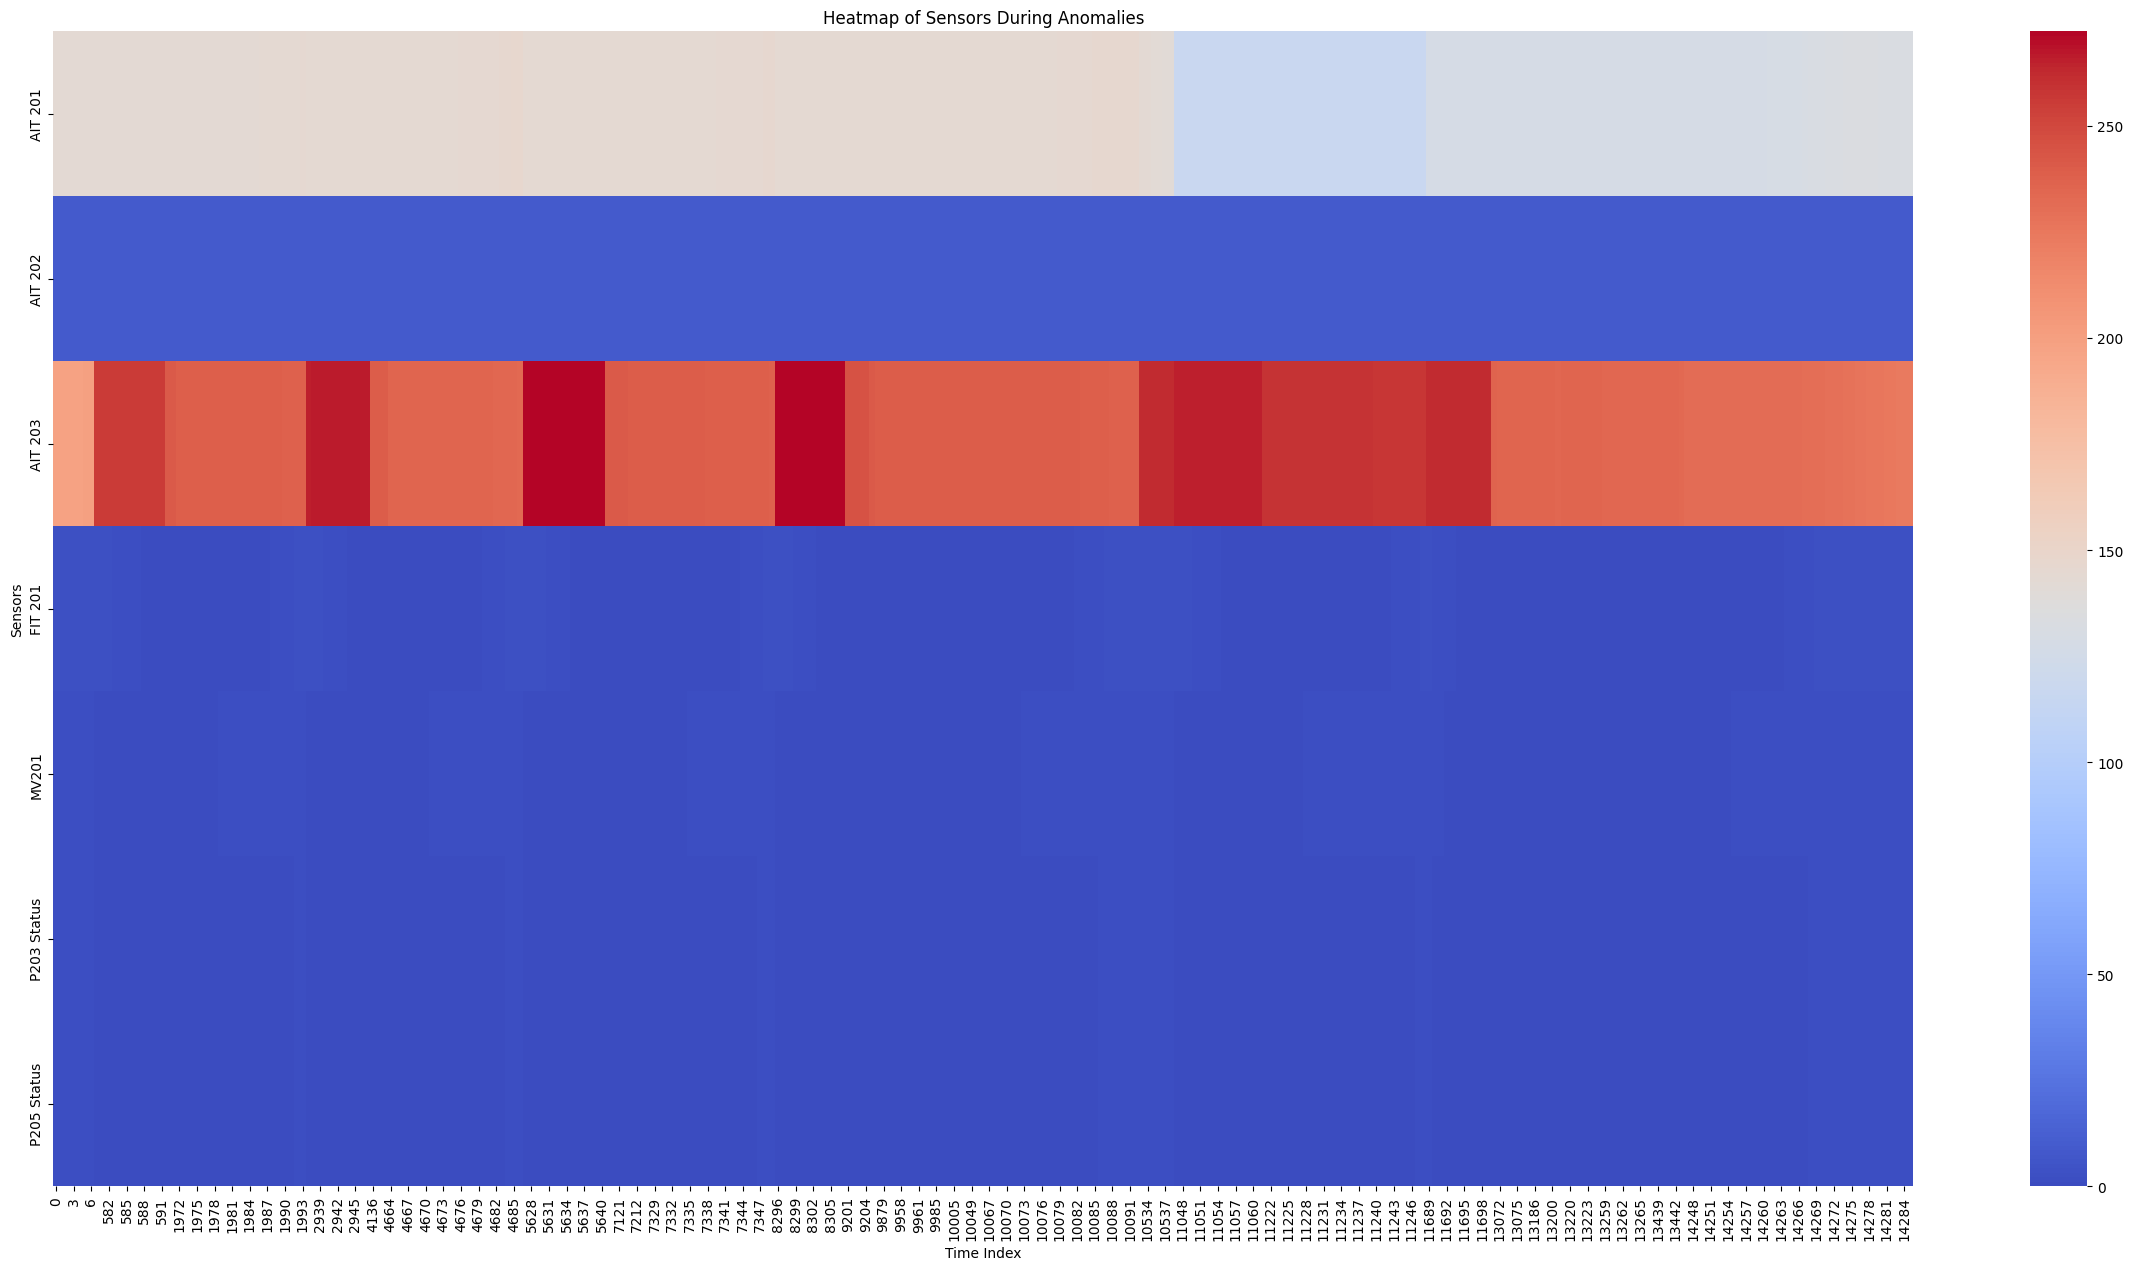

Total anomalies detected by PCA: 191
Total anomalies detected by Isolation Forest: 150
Total anomalies detected by Local Outlier Factor: 150


Total common anomalies detected by all methods: 29
Total common anomalies detected by PCA and Isolation Forest: 111
Total common anomalies detected by PCA and Local Outlier Factor: 49
Total common anomalies detected by Isolation Forest and Local Outlier Factor: 43


In [89]:
p2 = prepare_dfs([p2_])
scaled_data = scale_data(p2)

#### ***PCA***
pca_components, pca = pca_(scaled_data)
reconstruction_error, threshold_pca, anomalies_pca = metrics_pca(pca, scaled_data)

#### ***Isolation Forest***
anomaly_scores_iso, anomalies_iforest = metrics_iso_forest(scaled_data)

#### ***Local Outlier Factor***
anomaly_scores_lof, anomalies_lof = metrics_lof(scaled_data)

#### ***Combining Anomalies***
combined_anomalies = anomalies_pca | anomalies_iforest | anomalies_lof
combined_anomalies_p2_and = anomalies_pca & anomalies_iforest & anomalies_lof

p2['Anomaly'] = combined_anomalies
p2['Reconstruction_Error'] = reconstruction_error
p2['Isolation_Score'] = anomaly_scores_iso
p2['Lof_Score'] = anomaly_scores_lof

plot_reconstruction_error()
plot_heatmap(p2)

print(f"Total anomalies detected by PCA: {np.sum(anomalies_pca)}")
print(f"Total anomalies detected by Isolation Forest: {np.sum(anomalies_iforest)}")
print(f"Total anomalies detected by Local Outlier Factor: {np.sum(anomalies_lof)}\n\n")

check_common_anomalies_3methods(anomalies_pca, anomalies_iforest, anomalies_lof)

## ***Single Stage Multi Point (SSMP) - P3***

Scaled data shape: (14996, 12)
PCA Components: (14996, 7)
Number of anomalies: 213


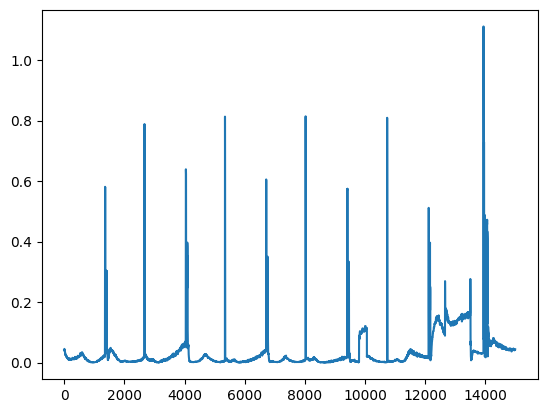

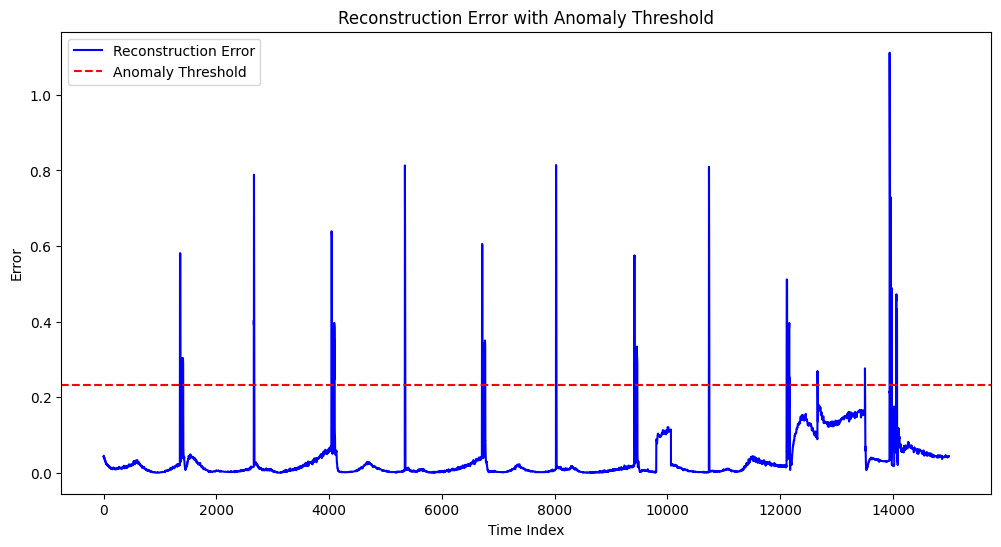

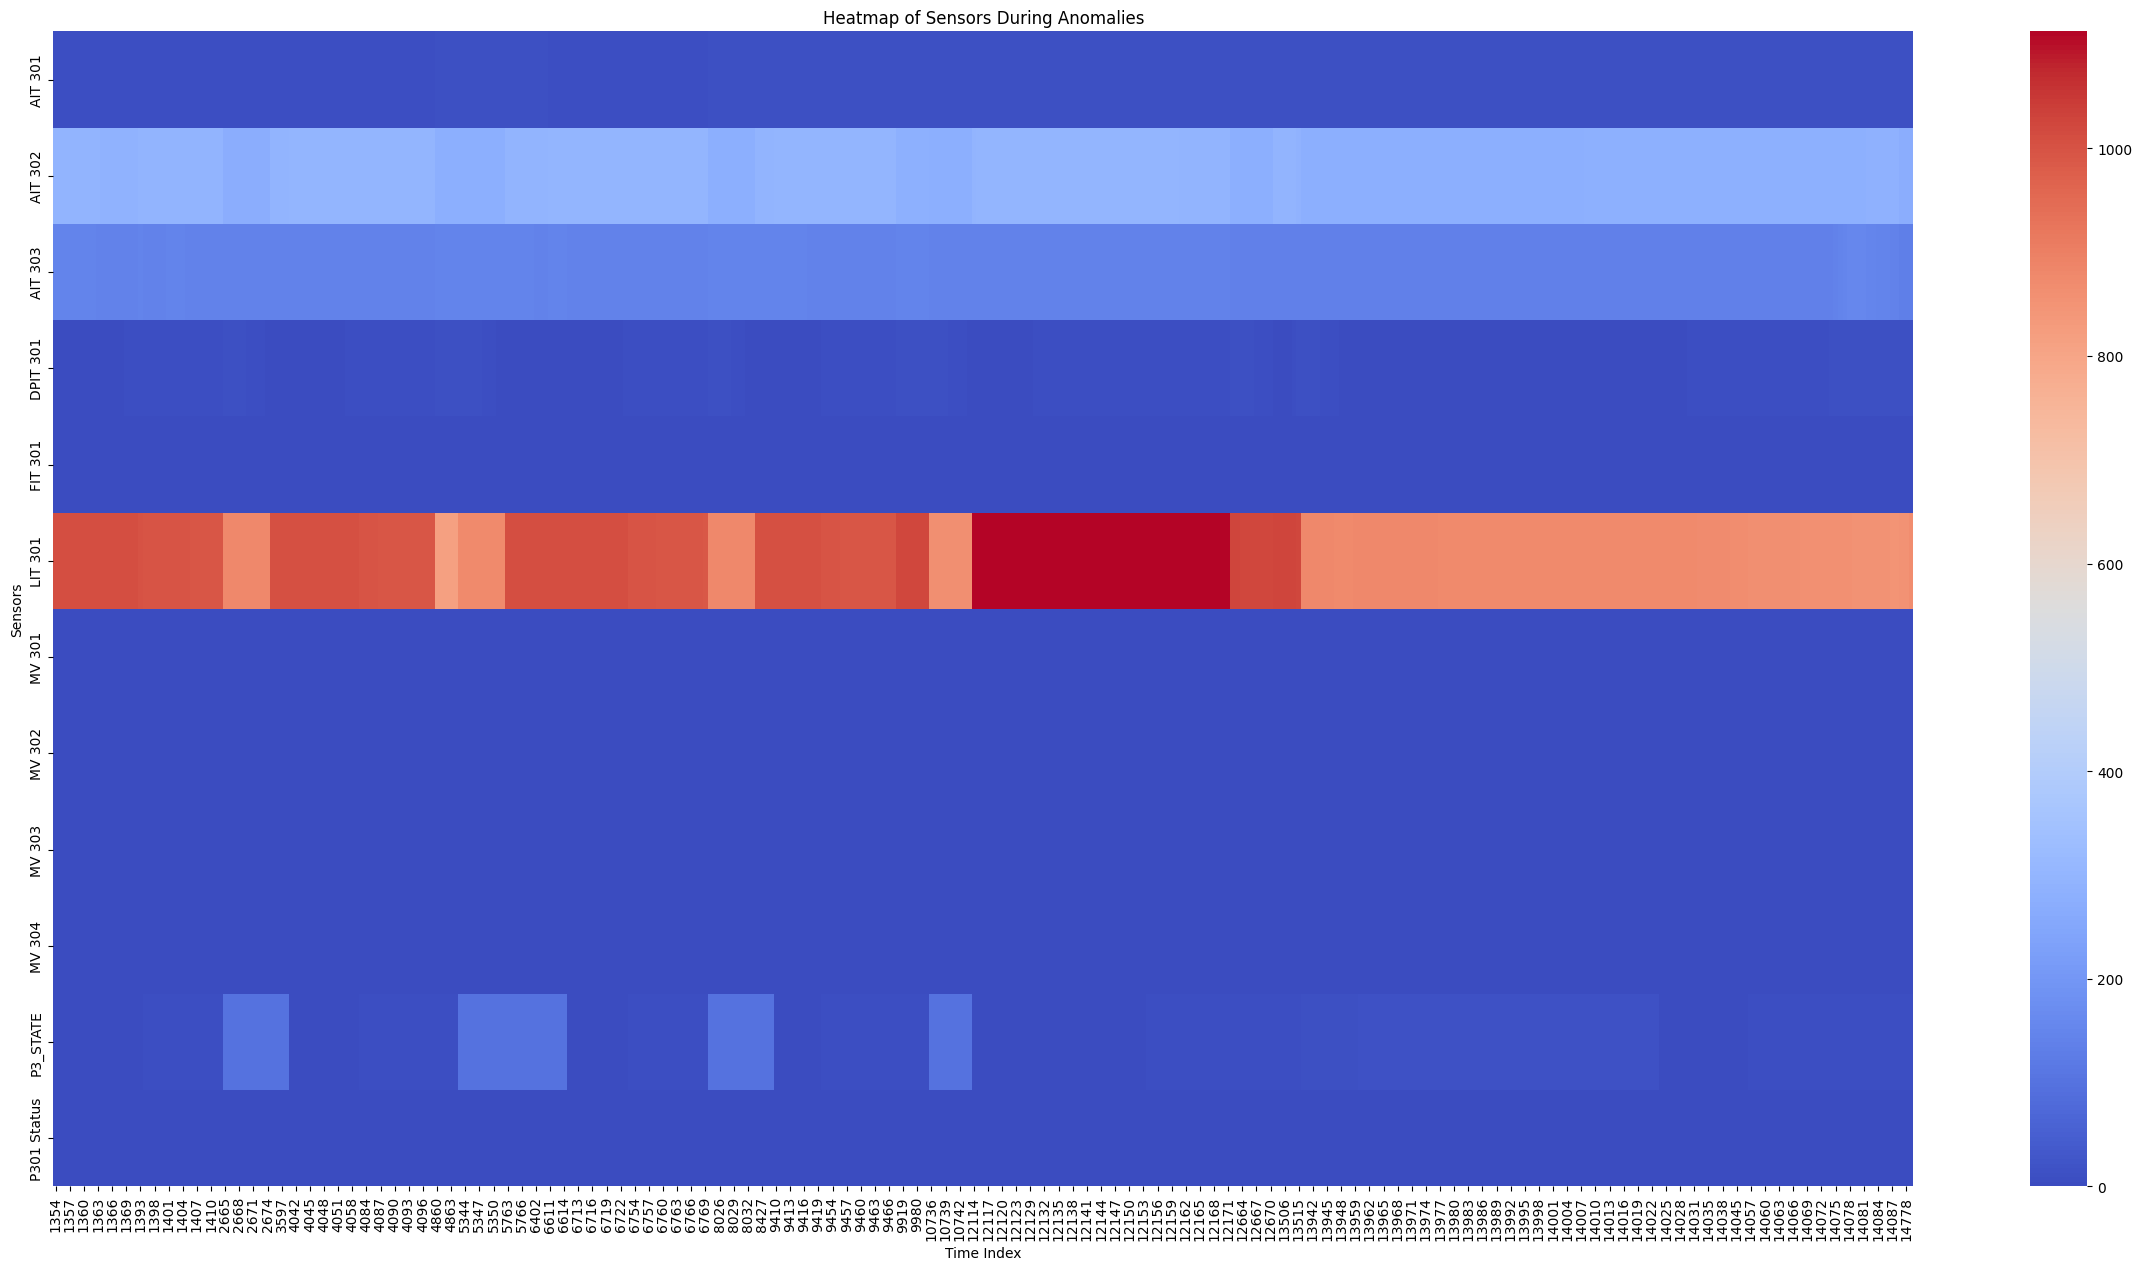

Total anomalies detected by PCA: 213
Total anomalies detected by Isolation Forest: 150
Total anomalies detected by Local Outlier Factor: 150


Total common anomalies detected by all methods: 22
Total common anomalies detected by PCA and Isolation Forest: 52
Total common anomalies detected by PCA and Local Outlier Factor: 56
Total common anomalies detected by Isolation Forest and Local Outlier Factor: 32


In [90]:
p3 = prepare_dfs([p3_])
scaled_data = scale_data(p3)

#### ***PCA***
pca_components, pca = pca_(scaled_data)
reconstruction_error, threshold_pca, anomalies_pca = metrics_pca(pca, scaled_data)

#### ***Isolation Forest***
anomaly_scores_iso, anomalies_iforest = metrics_iso_forest(scaled_data)

#### ***Local Outlier Factor***
anomaly_scores_lof, anomalies_lof = metrics_lof(scaled_data)

#### ***Combining Anomalies***
combined_anomalies = anomalies_pca | anomalies_iforest | anomalies_lof
combined_anomalies_p3_and = anomalies_pca & anomalies_iforest & anomalies_lof

p3['Anomaly'] = combined_anomalies
p3['Reconstruction_Error'] = reconstruction_error
p3['Isolation_Score'] = anomaly_scores_iso
p3['Lof_Score'] = anomaly_scores_lof

plot_reconstruction_error()
plot_heatmap(p3)

print(f"Total anomalies detected by PCA: {np.sum(anomalies_pca)}")
print(f"Total anomalies detected by Isolation Forest: {np.sum(anomalies_iforest)}")
print(f"Total anomalies detected by Local Outlier Factor: {np.sum(anomalies_lof)}\n\n")

check_common_anomalies_3methods(anomalies_pca, anomalies_iforest, anomalies_lof)

## ***Single Stage Multi Point (SSMP) - P4***

Scaled data shape: (14996, 5)
PCA Components: (14996, 4)
Number of anomalies: 12


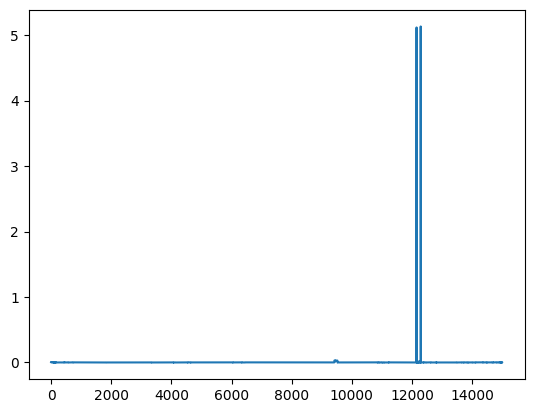

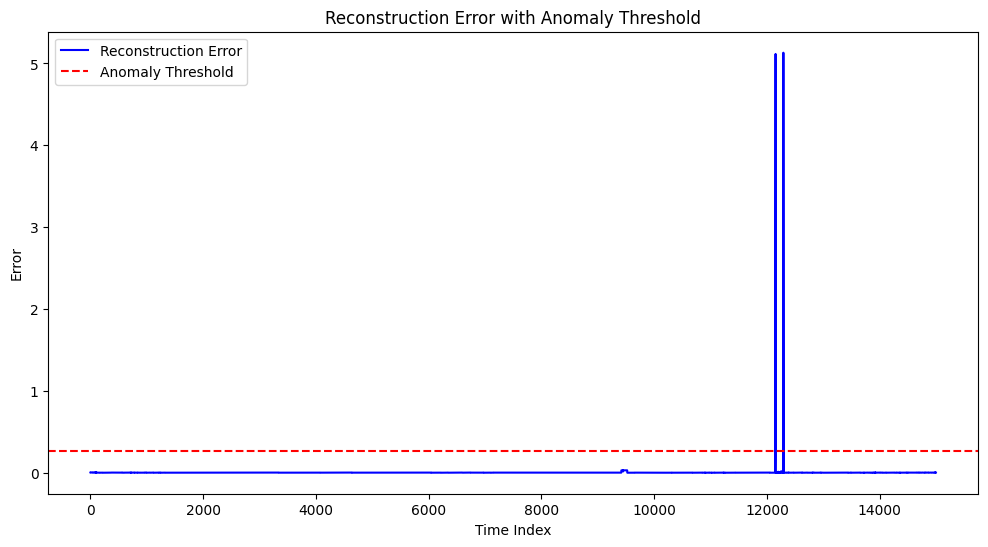

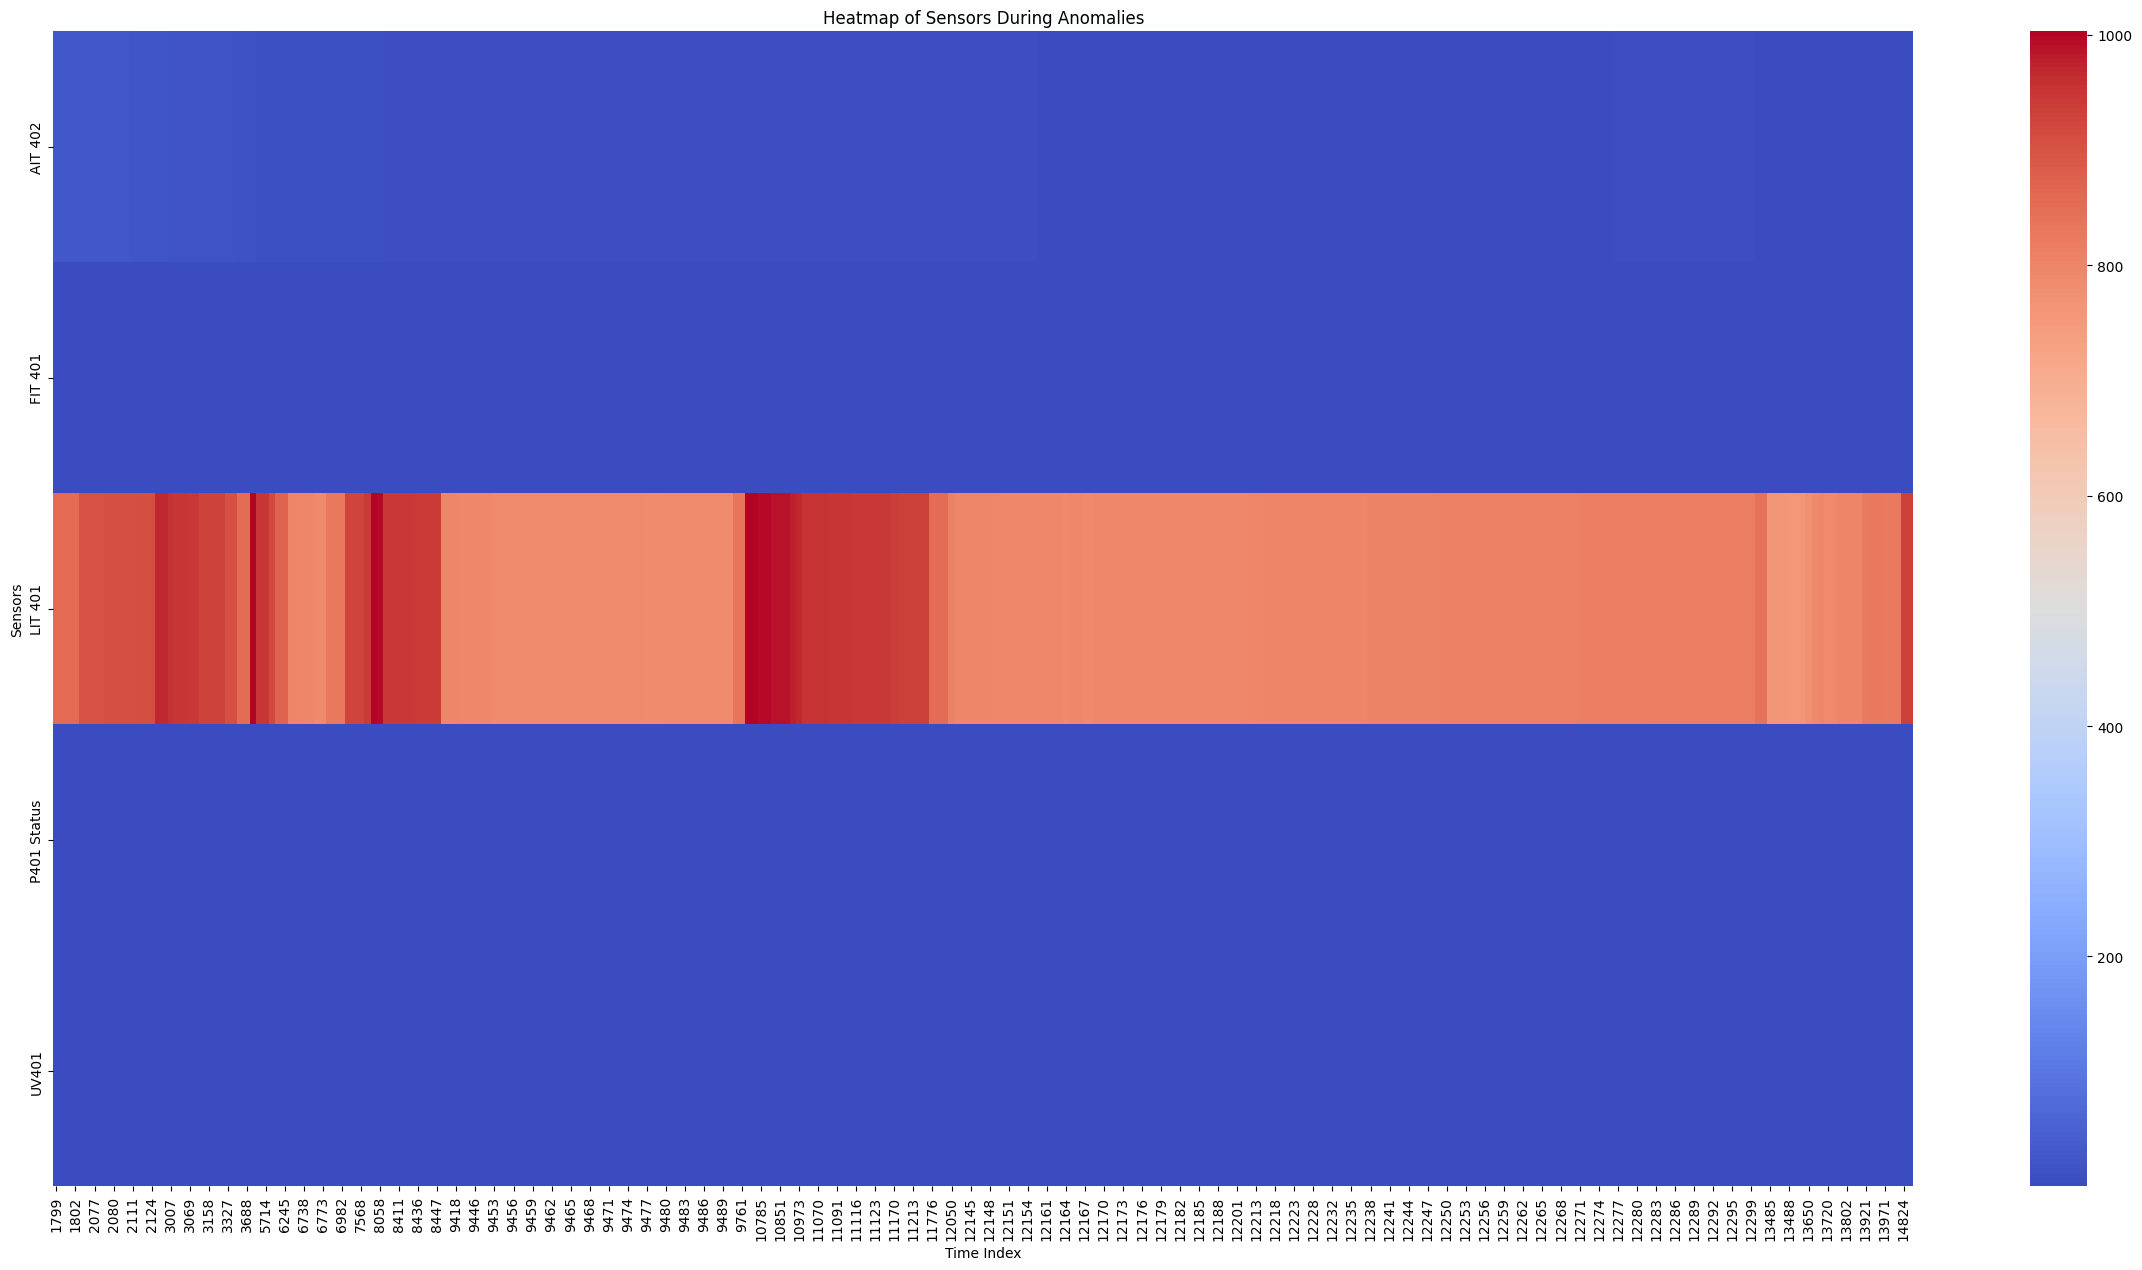

Total anomalies detected by PCA: 12
Total anomalies detected by Isolation Forest: 147
Total anomalies detected by Local Outlier Factor: 150


Total common anomalies detected by all methods: 0
Total common anomalies detected by PCA and Isolation Forest: 0
Total common anomalies detected by PCA and Local Outlier Factor: 12
Total common anomalies detected by Isolation Forest and Local Outlier Factor: 4


In [91]:
p4 = prepare_dfs([p4_])
scaled_data = scale_data(p4)

#### ***PCA***
pca_components, pca = pca_(scaled_data)
reconstruction_error, threshold_pca, anomalies_pca = metrics_pca(pca, scaled_data)

#### ***Isolation Forest***
anomaly_scores_iso, anomalies_iforest = metrics_iso_forest(scaled_data)

#### ***Local Outlier Factor***
anomaly_scores_lof, anomalies_lof = metrics_lof(scaled_data)

#### ***Combining Anomalies***
combined_anomalies = anomalies_pca | anomalies_iforest | anomalies_lof
combined_anomalies_p4_and = anomalies_pca & anomalies_iforest & anomalies_lof

p4['Anomaly'] = combined_anomalies
p4['Reconstruction_Error'] = reconstruction_error
p4['Isolation_Score'] = anomaly_scores_iso
p4['Lof_Score'] = anomaly_scores_lof

plot_reconstruction_error()
plot_heatmap(p4)

print(f"Total anomalies detected by PCA: {np.sum(anomalies_pca)}")
print(f"Total anomalies detected by Isolation Forest: {np.sum(anomalies_iforest)}")
print(f"Total anomalies detected by Local Outlier Factor: {np.sum(anomalies_lof)}\n\n")

check_common_anomalies_3methods(anomalies_pca, anomalies_iforest, anomalies_lof)

## ***Single Stage Multi Point (SSMP) - P5***

Scaled data shape: (14996, 12)
PCA Components: (14996, 5)
Number of anomalies: 43


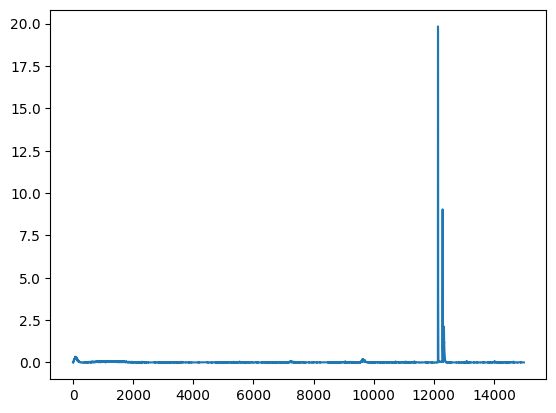

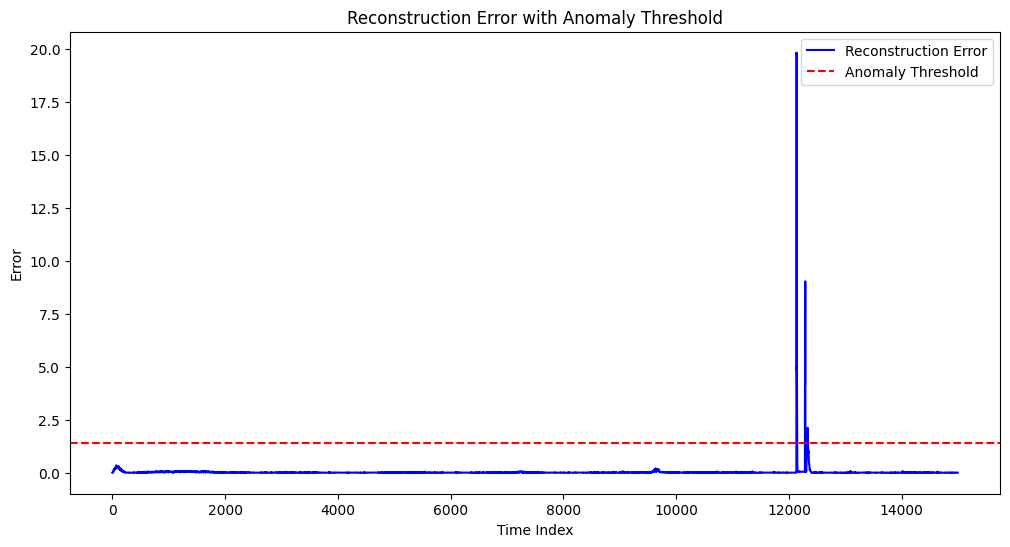

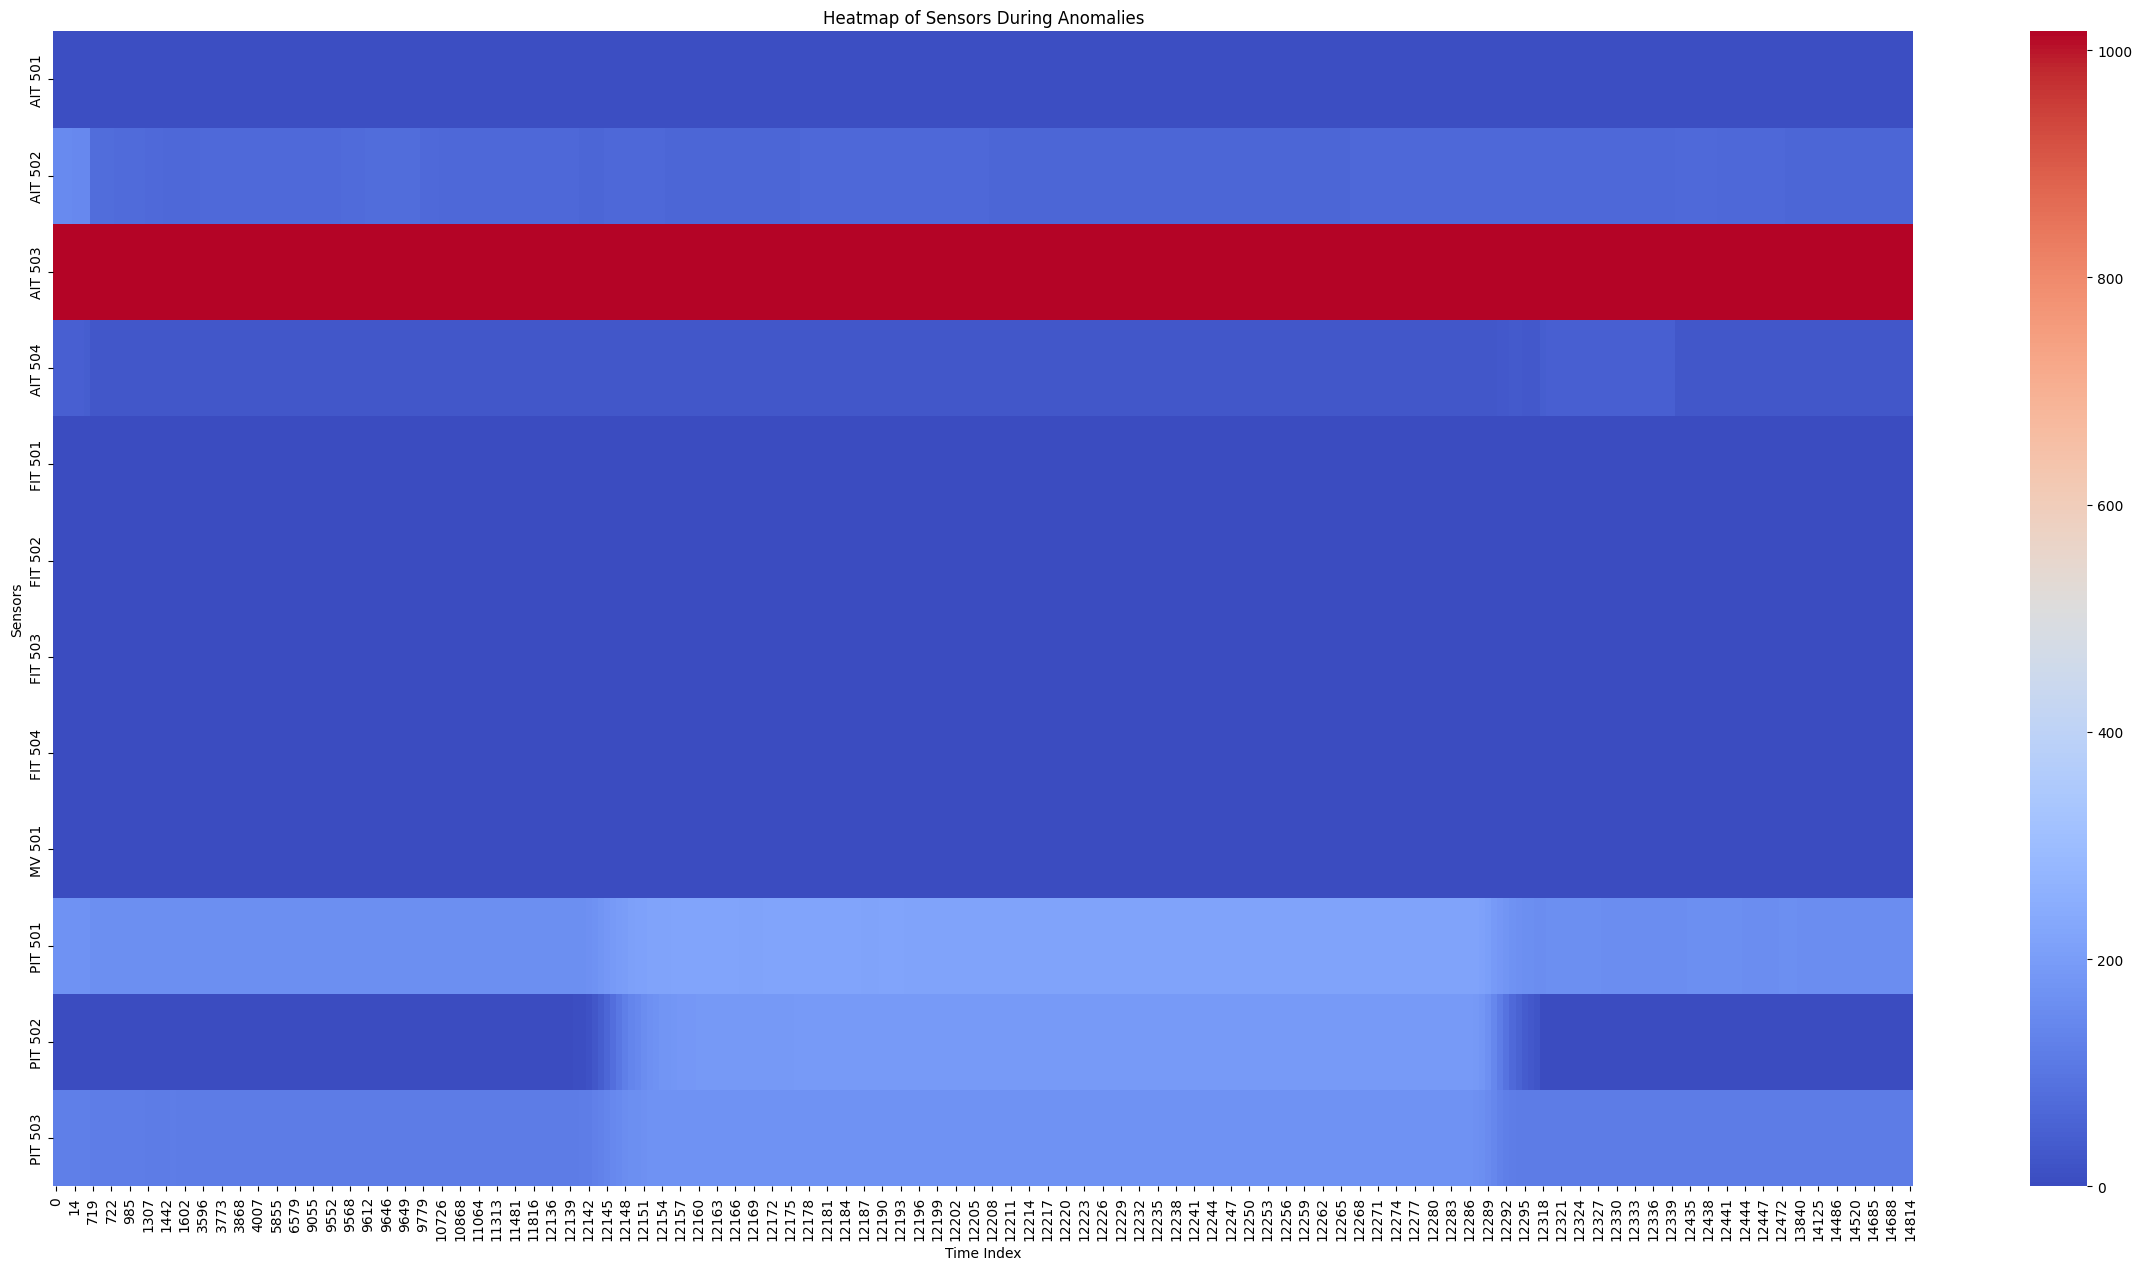

Total anomalies detected by PCA: 43
Total anomalies detected by Isolation Forest: 149
Total anomalies detected by Local Outlier Factor: 150


Total common anomalies detected by all methods: 5
Total common anomalies detected by PCA and Isolation Forest: 5
Total common anomalies detected by PCA and Local Outlier Factor: 20
Total common anomalies detected by Isolation Forest and Local Outlier Factor: 18


In [92]:
p5 = prepare_dfs([p5_])
scaled_data = scale_data(p5)

#### ***PCA***
pca_components, pca = pca_(scaled_data)
reconstruction_error, threshold_pca, anomalies_pca = metrics_pca(pca, scaled_data)

#### ***Isolation Forest***
anomaly_scores_iso, anomalies_iforest = metrics_iso_forest(scaled_data)

#### ***Local Outlier Factor***
anomaly_scores_lof, anomalies_lof = metrics_lof(scaled_data)

#### ***Combining Anomalies***
combined_anomalies = anomalies_pca | anomalies_iforest | anomalies_lof
combined_anomalies_p5_and = anomalies_pca & anomalies_iforest & anomalies_lof

p5['Anomaly'] = combined_anomalies
p5['Reconstruction_Error'] = reconstruction_error
p5['Isolation_Score'] = anomaly_scores_iso
p5['Lof_Score'] = anomaly_scores_lof

plot_reconstruction_error()
plot_heatmap(p5)

print(f"Total anomalies detected by PCA: {np.sum(anomalies_pca)}")
print(f"Total anomalies detected by Isolation Forest: {np.sum(anomalies_iforest)}")
print(f"Total anomalies detected by Local Outlier Factor: {np.sum(anomalies_lof)}\n\n")

check_common_anomalies_3methods(anomalies_pca, anomalies_iforest, anomalies_lof)

## ***Single Stage Multi Point (SSMP) - P6***

Scaled data shape: (14996, 3)
PCA Components: (14996, 3)
Number of anomalies: 243


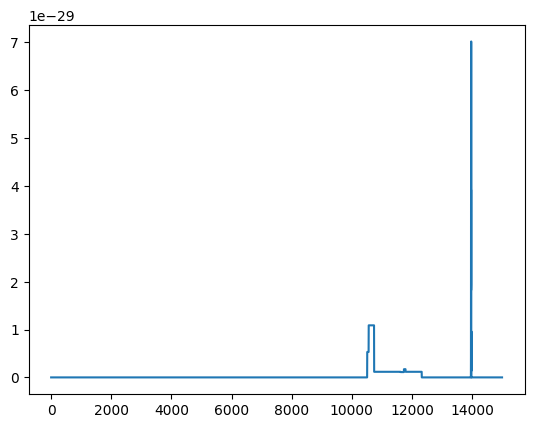

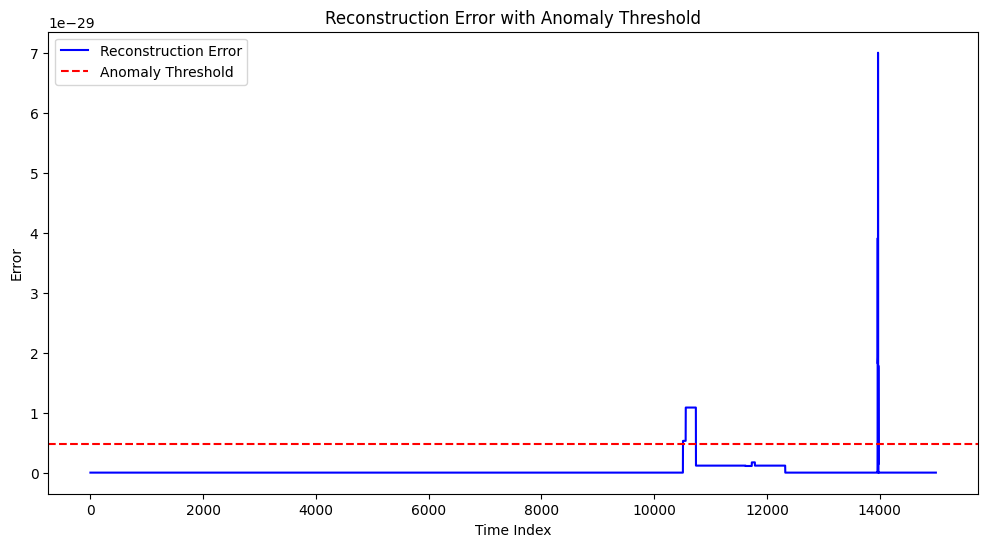

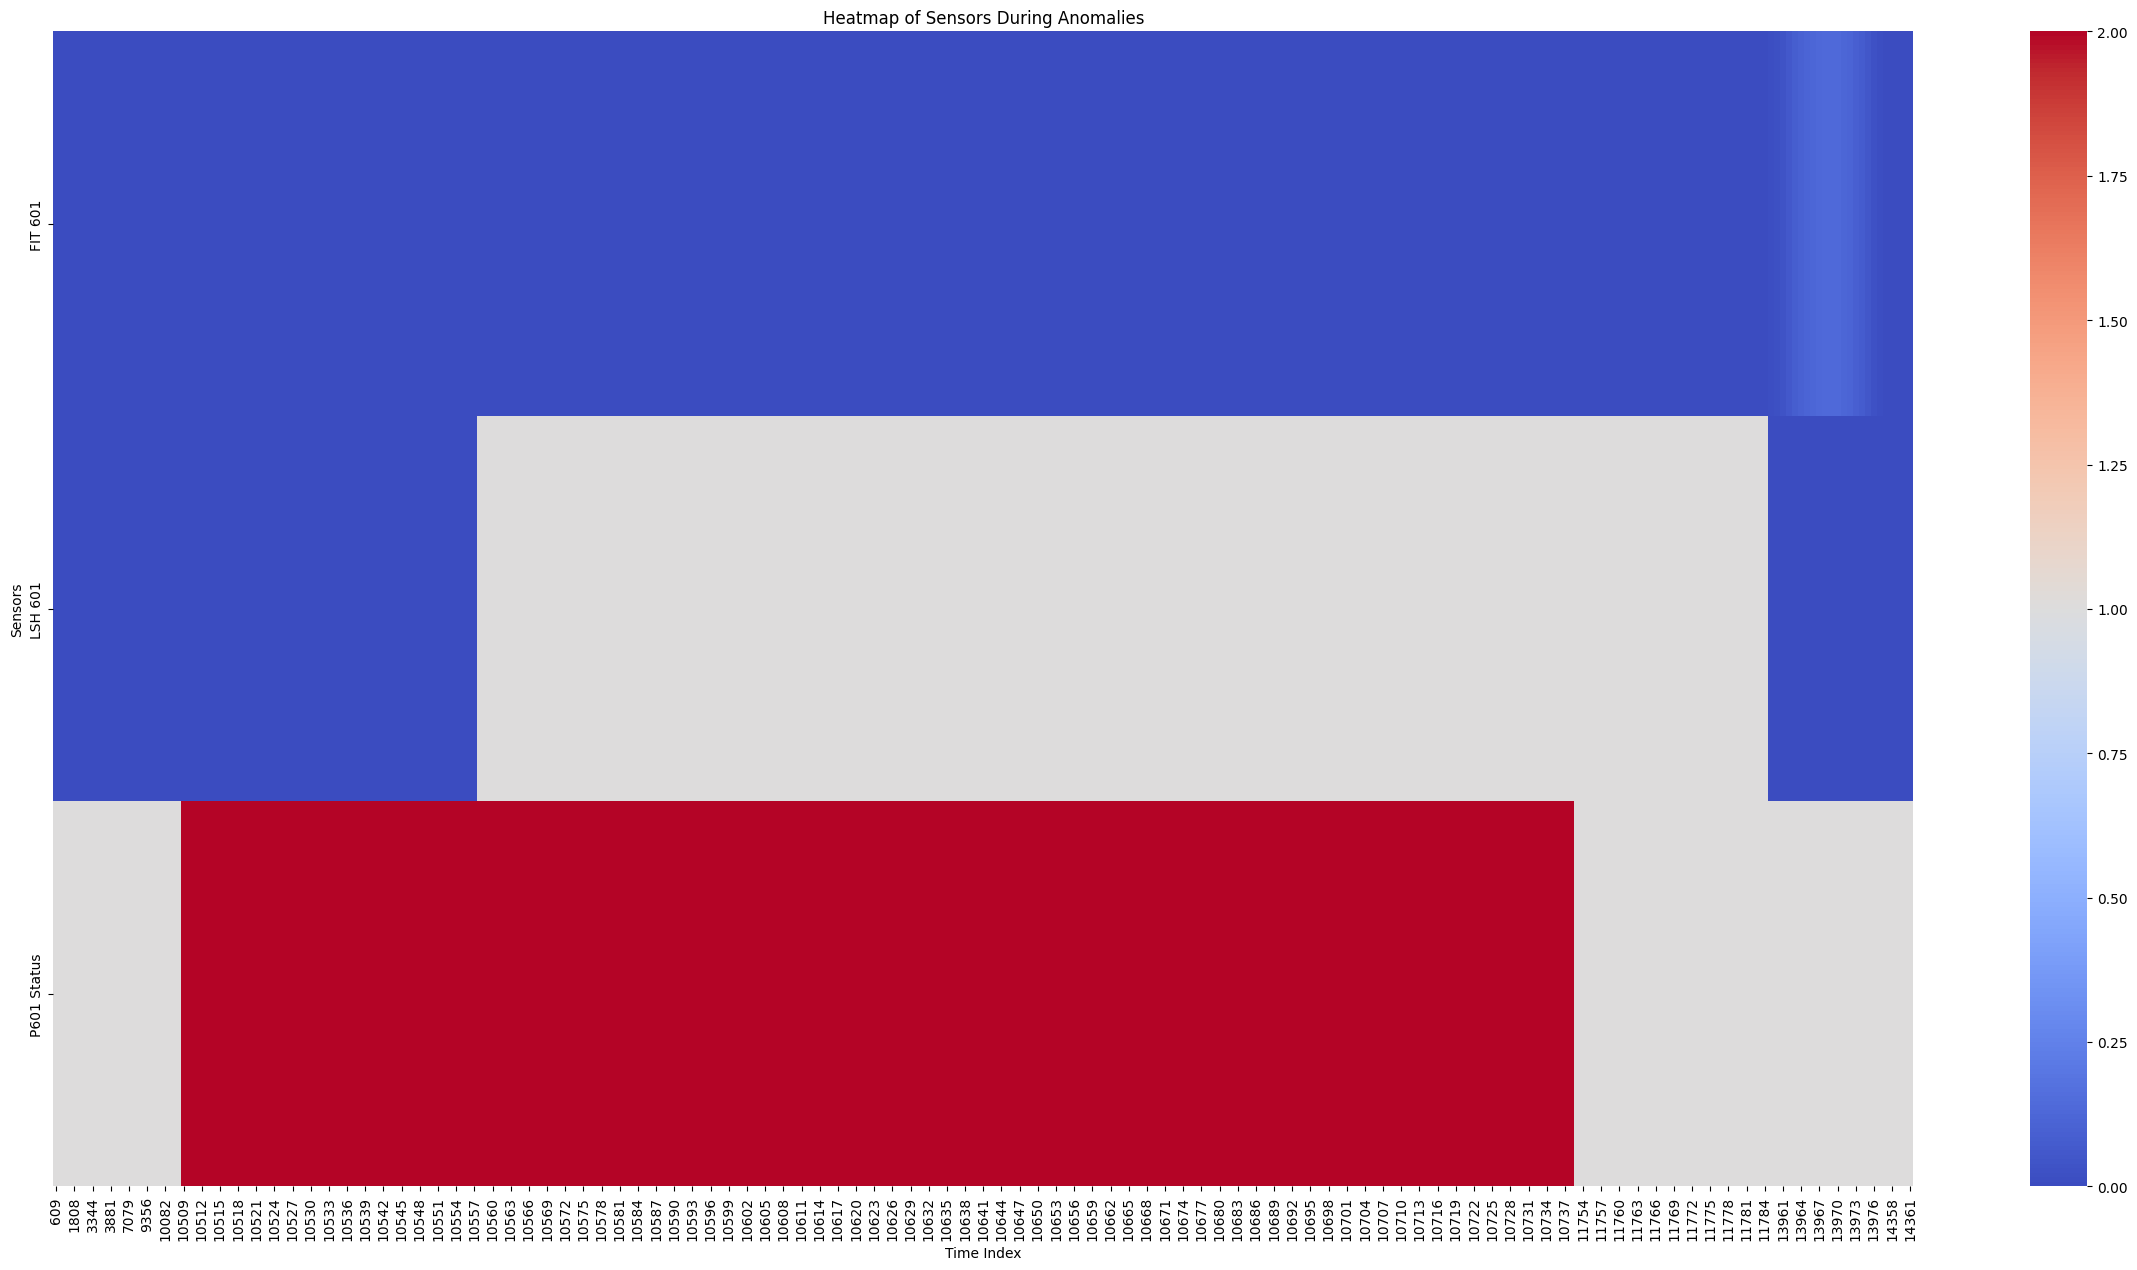

Total anomalies detected by PCA: 243
Total anomalies detected by Isolation Forest: 32
Total anomalies detected by Local Outlier Factor: 45


Total common anomalies detected by all methods: 0
Total common anomalies detected by PCA and Isolation Forest: 0
Total common anomalies detected by PCA and Local Outlier Factor: 13
Total common anomalies detected by Isolation Forest and Local Outlier Factor: 0


In [93]:
p6 = prepare_dfs([p6_])
scaled_data = scale_data(p6)

#### ***PCA***
pca_components, pca = pca_(scaled_data)
reconstruction_error, threshold_pca, anomalies_pca = metrics_pca(pca, scaled_data)

#### ***Isolation Forest***
anomaly_scores_iso, anomalies_iforest = metrics_iso_forest(scaled_data)

#### ***Local Outlier Factor***
anomaly_scores_lof, anomalies_lof = metrics_lof(scaled_data)

#### ***Combining Anomalies***
combined_anomalies = anomalies_pca | anomalies_iforest | anomalies_lof
combined_anomalies_p6_and = anomalies_pca & anomalies_iforest & anomalies_lof

p6['Anomaly'] = combined_anomalies
p6['Reconstruction_Error'] = reconstruction_error
p6['Isolation_Score'] = anomaly_scores_iso
p6['Lof_Score'] = anomaly_scores_lof

plot_reconstruction_error()
plot_heatmap(p6)

print(f"Total anomalies detected by PCA: {np.sum(anomalies_pca)}")
print(f"Total anomalies detected by Isolation Forest: {np.sum(anomalies_iforest)}")
print(f"Total anomalies detected by Local Outlier Factor: {np.sum(anomalies_lof)}\n\n")

check_common_anomalies_3methods(anomalies_pca, anomalies_iforest, anomalies_lof)

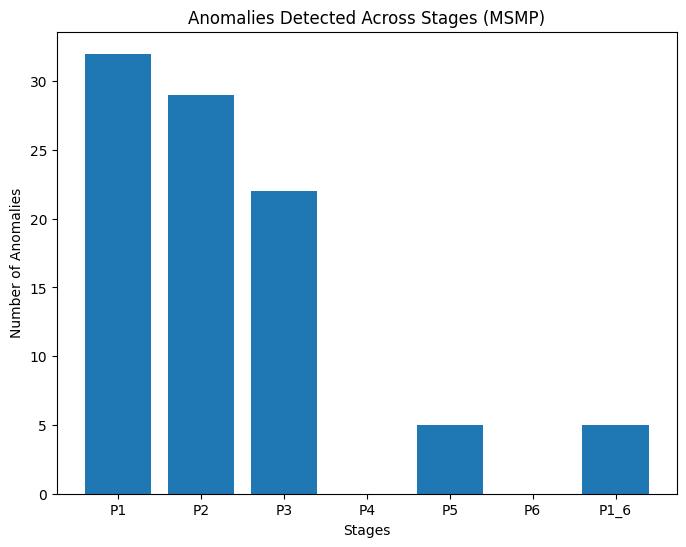

In [94]:
anomalies_count = {
    "P1": np.sum(combined_anomalies_p1_and),
    "P2": np.sum(combined_anomalies_p2_and),
    "P3": np.sum(combined_anomalies_p3_and),
    "P4": np.sum(combined_anomalies_p4_and),
    "P5": np.sum(combined_anomalies_p5_and),
    "P6": np.sum(combined_anomalies_p6_and),
    "P1_6": np.sum(combined_anomalies_p1_6_and)
}

plt.figure(figsize=(8, 6))
plt.bar(anomalies_count.keys(), anomalies_count.values())
plt.title('Anomalies Detected Across Stages (MSMP)')
plt.ylabel('Number of Anomalies')
plt.xlabel('Stages')
plt.show()


In [95]:
combined_anomalies = (
    combined_anomalies_p1_and | combined_anomalies_p2_and | combined_anomalies_p3_and
     | combined_anomalies_p5_and | combined_anomalies_p1_6_and
)
total_anomalies = combined_anomalies


In [96]:
print("Total counted anomalies combined, ", total_anomalies.sum())

Total counted anomalies combined,  88


In [97]:
print("Classification Report:")
print(classification_report(true_labels, total_anomalies))

print("Confusion Matrix:")
cm_combined = confusion_matrix(true_labels, total_anomalies)
print(cm_combined)

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.99      0.90     12443
           1       0.22      0.01      0.01      2553

    accuracy                           0.83     14996
   macro avg       0.52      0.50      0.46     14996
weighted avg       0.73      0.83      0.75     14996

Confusion Matrix:
[[12374    69]
 [ 2534    19]]


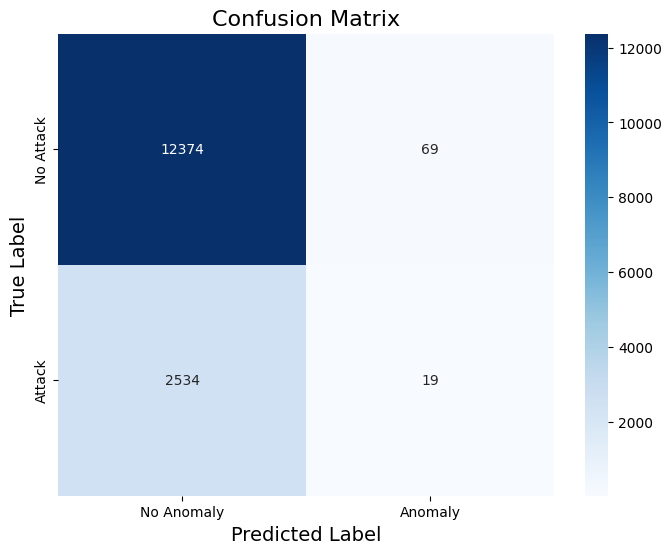

In [98]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm_combined, annot=True, fmt='d', cmap='Blues', xticklabels=['No Anomaly', 'Anomaly'], yticklabels=['No Attack', 'Attack'])
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.show()

# ***Attack types***
The provided paper tells us this:

0. Total number of attacks: 36.
1. ***SSSP***: 26
2. ***SSMP***: 4
3. ***MSSP***: 2
4. ***MSMP***: 4

# ***Deep Learning Approaches***

In [99]:
df_for_mlp = prepare_dfs([labels, p1_, p2_, p3_, p4_, p5_, p6_])

In [100]:
df_for_mlp.head()

,Label,FIT 101,LIT 101,MV 101,P1_STATE,P101 Status,AIT 201,AIT 202,AIT 203,FIT 201,...,FIT 502,FIT 503,FIT 504,MV 501,PIT 501,PIT 502,PIT 503,FIT 601,LSH 601,P601 Status
0,0,0.0,729.8658,1,3,2,142.527557,9.293002,198.077423,2.335437,...,0.310362,0.623628,0.213432,2,167.601257,2.963509,119.921173,0.00032,0,1
1,0,0.0,729.4340,1,3,2,142.527557,9.293002,198.385025,2.335437,...,0.315102,0.623628,0.212984,2,167.601257,2.963509,119.921173,0.00032,0,1
2,0,0.0,729.1200,1,3,2,142.527557,9.293002,198.436300,2.335437,...,0.317023,0.623628,0.212984,2,167.601257,2.963509,119.921173,0.00032,0,1
3,0,0.0,728.6882,1,3,2,142.527557,9.289157,198.667000,2.335437,...,0.308057,0.623628,0.212792,2,167.601257,2.963509,119.921173,0.00032,0,1
4,0,0.0,727.7069,1,3,2,142.527557,9.289157,198.897720,2.335437,...,0.303446,0.623628,0.214009,2,167.601257,2.963509,119.921173,0.00032,0,1


In [101]:
X = df_for_mlp.drop(['Label'], axis=1)  # Features
y = df_for_mlp['Label'].astype(int)  # Labels (0 or 1)

In [102]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = Sequential([
    Dense(64, activation='relu', input_dim=X_train.shape[1]),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.2)

y_pred = model.predict(X_test)
y_pred_labels = (y_pred > 0.5).astype(int)

print(classification_report(y_test, y_pred_labels))

Epoch 1/30


c:\Users\rokra\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7189 - loss: 8.3434 - val_accuracy: 0.8248 - val_loss: 0.5564
Epoch 2/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8680 - loss: 0.3057 - val_accuracy: 0.8986 - val_loss: 0.2086
Epoch 3/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step - accuracy: 0.8769 - loss: 0.3222 - val_accuracy: 0.8810 - val_loss: 0.2920
Epoch 4/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8937 - loss: 0.2953 - val_accuracy: 0.9281 - val_loss: 0.2109
Epoch 5/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step - accuracy: 0.8888 - loss: 0.3402 - val_accuracy: 0.9129 - val_loss: 0.1727
Epoch 6/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 927us/step - accuracy: 0.9030 - loss: 0.2269 - val_accuracy: 0.9105 - val_loss: 0.2065
Epoch 7/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step - accuracy: 0.8986 - loss: 0.2455 - val_accuracy: 0.9014 - val_loss: 0.3830
Epoch 8/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9085 - loss: 0.2249 - val_accuracy: 0.922

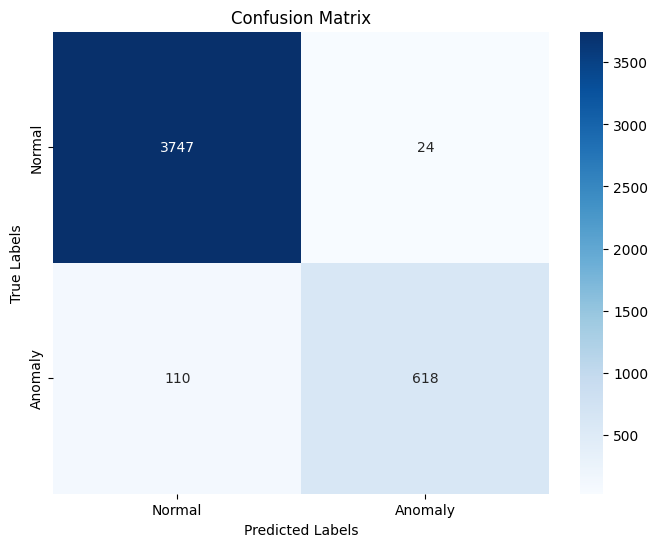

In [103]:
cm = confusion_matrix(y_test, y_pred_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


# ***ATTACKS TYPES WITHOUT LABELS***

In [104]:
df_for_mlp_types = pd.concat([attacks, prepare_dfs([p1_, p2_, p3_, p4_, p5_, p6_])], axis=1).copy()

In [105]:
df_for_mlp_types['Attack'].unique()

array(['benign', 'Spoofing', 'Switch_ON', 'Switch_close', 'Switch_off'],
      dtype=object)

In [ ]:
df_for_mlp_types.head()

,Attack,Attack_Group,FIT 101,LIT 101,MV 101,P1_STATE,P101 Status,AIT 201,AIT 202,AIT 203,...,FIT 502,FIT 503,FIT 504,MV 501,PIT 501,PIT 502,PIT 503,FIT 601,LSH 601,P601 Status
0,benign,1,0.0,729.8658,1,3,2,142.527557,9.293002,198.077423,...,0.310362,0.623628,0.213432,2,167.601257,2.963509,119.921173,0.00032,0,1
1,benign,1,0.0,729.4340,1,3,2,142.527557,9.293002,198.385025,...,0.315102,0.623628,0.212984,2,167.601257,2.963509,119.921173,0.00032,0,1
2,benign,1,0.0,729.1200,1,3,2,142.527557,9.293002,198.436300,...,0.317023,0.623628,0.212984,2,167.601257,2.963509,119.921173,0.00032,0,1
3,benign,1,0.0,728.6882,1,3,2,142.527557,9.289157,198.667000,...,0.308057,0.623628,0.212792,2,167.601257,2.963509,119.921173,0.00032,0,1
4,benign,1,0.0,727.7069,1,3,2,142.527557,9.289157,198.897720,...,0.303446,0.623628,0.214009,2,167.601257,2.963509,119.921173,0.00032,0,1


In [108]:
X_types = df_for_mlp_types.drop(['Attack'], axis=1)
y_types = df_for_mlp_types['Attack']

In [109]:
y_types_encoded = pd.get_dummies(y_types).values

X_train_types, X_test_types, y_train_types, y_test_types = train_test_split(X_types, y_types_encoded, test_size=0.3, random_state=42)

model_types = Sequential([
    Dense(64, activation='relu', input_dim=X_train_types.shape[1]),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(5, activation='softmax')
])

model_types.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model_types.fit(X_train_types, y_train_types, epochs=30, batch_size=32, validation_split=0.2)

y_pred_types = model_types.predict(X_test_types)
y_pred_labels_types = np.argmax(y_pred_types, axis=1)
y_test_labels_types = np.argmax(y_test_types, axis=1)

print(classification_report(y_test_labels_types, y_pred_labels_types, target_names=['benign', 'Spoofing', 'Switch_ON', 'Switch_close', 'Switch_off']))

Epoch 1/30


c:\Users\rokra\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7859 - loss: 10.0425 - val_accuracy: 0.8257 - val_loss: 1.2603
Epoch 2/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8742 - loss: 0.6205 - val_accuracy: 0.8581 - val_loss: 0.7880
Epoch 3/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8829 - loss: 0.7960 - val_accuracy: 0.8819 - val_loss: 0.8086
Epoch 4/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9008 - loss: 0.4821 - val_accuracy: 0.9414 - val_loss: 0.6869
Epoch 5/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8993 - loss: 0.5782 - val_accuracy: 0.9162 - val_loss: 0.3315
Epoch 6/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9172 - loss: 0.4327 - val_accuracy: 0.9443 - val_loss: 0.1934
Epoch 7/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step - accuracy: 0.9226 - loss: 0.3267 - val_accuracy: 0.9705 - val_loss: 0.1046
Epoch 8/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9478 - loss: 0.2091 - val_accuracy: 0.9005 - v

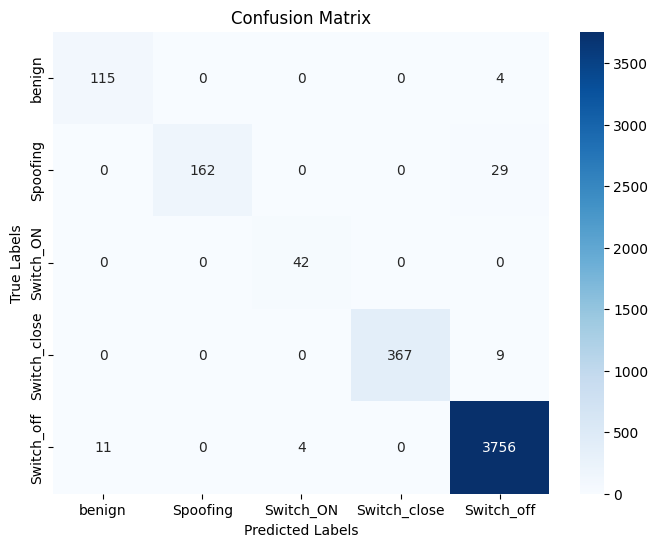

In [110]:
conf_matrix = confusion_matrix(y_test_labels_types, y_pred_labels_types)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['benign', 'Spoofing', 'Switch_ON', 'Switch_close', 'Switch_off'], 
            yticklabels=['benign', 'Spoofing', 'Switch_ON', 'Switch_close', 'Switch_off'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# ***ATTACK TYPES WITH LABELS***

In [111]:
df_for_mlp_types_labels = pd.concat([attacks, labels, prepare_dfs([p1_, p2_, p3_, p4_, p5_, p6_])], axis=1).copy()

In [112]:
X_types_labels = df_for_mlp_types_labels.drop(['Attack'], axis=1)
y_types_labels = df_for_mlp_types_labels['Attack']

In [113]:
y_types_encoded_labels = pd.get_dummies(y_types_labels).values

X_train_types_labels, X_test_types_labels, y_train_types_labels, y_test_types_labels = train_test_split(X_types_labels, y_types_encoded_labels, test_size=0.3, random_state=42)

model_types_labels = Sequential([
    Dense(64, activation='relu', input_dim=X_train_types_labels.shape[1]),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(5, activation='softmax')
])

model_types_labels.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model_types_labels.fit(X_train_types_labels, y_train_types_labels, epochs=30, batch_size=32, validation_split=0.2)

y_pred_types_labels = model_types_labels.predict(X_test_types_labels)
y_pred_labels_types_labels = np.argmax(y_pred_types_labels, axis=1)
y_test_labels_types_labels = np.argmax(y_test_types_labels, axis=1)

print(classification_report(y_test_labels_types, y_pred_labels_types, target_names=['benign', 'Spoofing', 'Switch_ON', 'Switch_close', 'Switch_off']))

Epoch 1/30


c:\Users\rokra\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6886 - loss: 30.5298 - val_accuracy: 0.8952 - val_loss: 0.2660
Epoch 2/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8680 - loss: 0.3907 - val_accuracy: 0.9157 - val_loss: 0.1862
Epoch 3/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8959 - loss: 0.2913 - val_accuracy: 0.9452 - val_loss: 0.2776
Epoch 4/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9144 - loss: 0.2702 - val_accuracy: 0.9276 - val_loss: 0.2072
Epoch 5/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9196 - loss: 0.2318 - val_accuracy: 0.9714 - val_loss: 0.1217
Epoch 6/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9367 - loss: 0.1670 - val_accuracy: 0.9195 - val_loss: 0.6198
Epoch 7/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9245 - loss: 0.3459 - val_accuracy: 0.9548 - val_loss: 0.1129
Epoch 8/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9514 - loss: 0.1409 - val_accuracy: 0.9629 - val

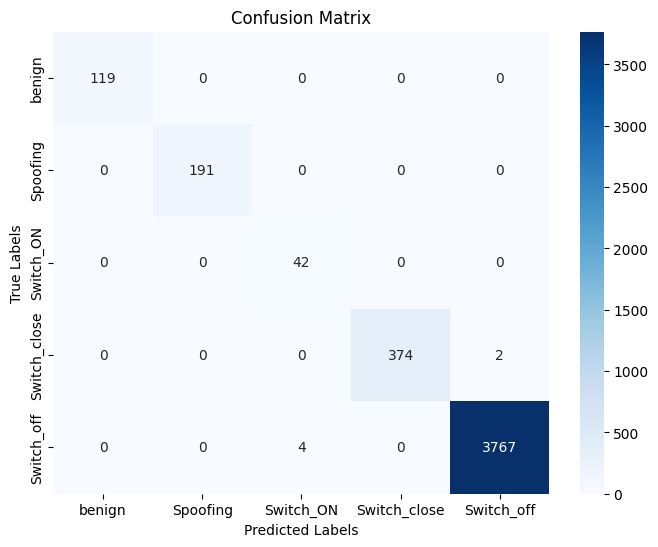

In [114]:
conf_matrix = confusion_matrix(y_test_labels_types_labels, y_pred_labels_types_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['benign', 'Spoofing', 'Switch_ON', 'Switch_close', 'Switch_off'], 
            yticklabels=['benign', 'Spoofing', 'Switch_ON', 'Switch_close', 'Switch_off'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Without Spoofing extrapolate ?

In [130]:
# Perform an initial train-test split
X = df_for_mlp_types_labels.drop(['Attack', 'Label'], axis=1)
y = df_for_mlp_types_labels['Label'].astype(int)

X_train, X_test, y_train, y_test, train_attacks, test_attacks = train_test_split(
    X, y, df_for_mlp_types_labels['Attack'], test_size=0.3, random_state=42
)

# Remove "Spoofing" from the training set
train_df = pd.concat([X_train, train_attacks, y_train], axis=1)
train_df = train_df[train_df['Attack'] != 'Spoofing']

X_train_filtered = train_df.drop(['Attack', 'Label'], axis=1)  # Features without Attack and Label
y_train_filtered = train_df['Label'].astype(int)  # Binary labels (0 or 1)

# Define the model
model_filtered = Sequential([
    Dense(64, activation='relu', input_dim=X_train_filtered.shape[1]),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

model_filtered.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model_filtered.fit(X_train_filtered, y_train_filtered, epochs=30, batch_size=32, validation_split=0.2)

# Evaluate the model on the test set
y_pred_filtered = model_filtered.predict(X_test)
y_pred_labels_filtered = (y_pred_filtered > 0.5).astype(int)

# Classification report and confusion matrix
print(classification_report(y_test, y_pred_labels_filtered))


Epoch 1/30


c:\Users\rokra\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8508 - loss: 2.2577 - val_accuracy: 0.9302 - val_loss: 0.2780
Epoch 2/30
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9113 - loss: 0.3873 - val_accuracy: 0.8849 - val_loss: 0.2720
Epoch 3/30
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9089 - loss: 0.3432 - val_accuracy: 0.9176 - val_loss: 0.4844
Epoch 4/30
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9082 - loss: 0.3923 - val_accuracy: 0.9298 - val_loss: 0.3009
Epoch 5/30
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9089 - loss: 0.3347 - val_accuracy: 0.8790 - val_loss: 0.4760
Epoch 6/30
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9203 - loss: 0.2778 - val_accuracy: 0.8463 - val_loss: 0.6728
Epoch 7/30
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9399 - loss: 0.2047 - val_accuracy: 0.9805 - val_loss: 0.0866
Epoch 8/30
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9635 - loss: 0.1070 - val_accuracy: 0.9283 - val_

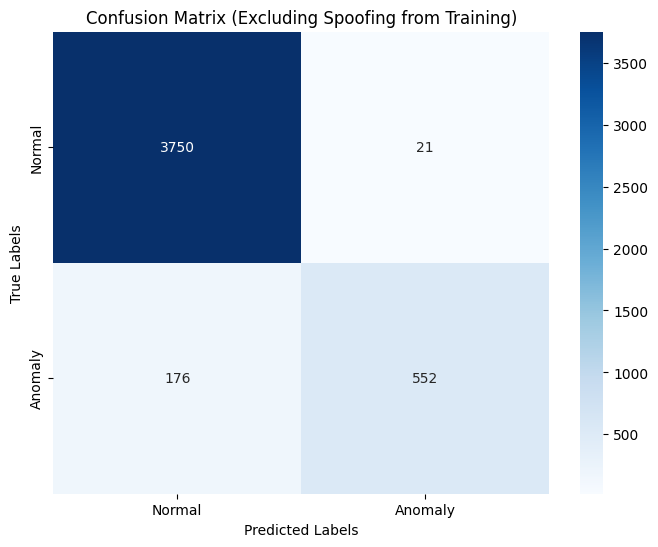

In [131]:
conf_matrix_filtered = confusion_matrix(y_test, y_pred_labels_filtered)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_filtered, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'])
plt.title('Confusion Matrix (Excluding Spoofing from Training)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

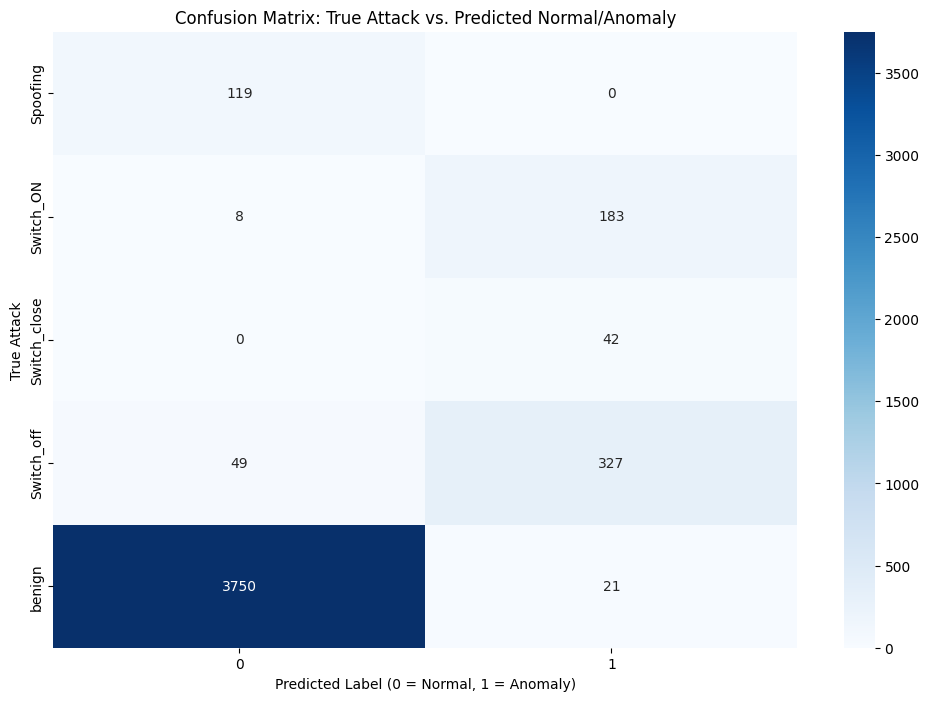

In [132]:
# Ensure lengths of all components align
test_attacks = test_attacks.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)
y_pred_labels_filtered = pd.Series(y_pred_labels_filtered.flatten(), index=y_test.index)

# Create the confusion matrix DataFrame
test_results = pd.DataFrame({
    'True Attack': test_attacks,
    'True Label': y_test,
    'Predicted Label': y_pred_labels_filtered
})

# Generate the confusion matrix: True Attack vs. Predicted Labels
conf_matrix_attack = pd.crosstab(
    test_results['True Attack'],
    test_results['Predicted Label'],
    rownames=['True Attack'],
    colnames=['Predicted Label'],
    dropna=False
)

# Plot the confusion matrix
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix_attack, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix: True Attack vs. Predicted Normal/Anomaly')
plt.xlabel('Predicted Label (0 = Normal, 1 = Anomaly)')
plt.ylabel('True Attack')
plt.show()